**Goal**: Compare the CodeGen attention to the human participants:
- Human vs Human (Inter-annotator agreement)
- Human vs Model (vectors of cumulative attention)
- Human vs Model (followup representation - token level)
    - MSE
    - Ranking based

In [1]:
import project_path
import os
import numpy as np
import json
from tqdm import tqdm
from typing import List, Dict, Any, Union, Tuple
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import pandas as pd

from attwizard.decoder import get_attention_representation
from attwizard.aligner import map_to_char_level
from attwizard.aligner import tokenize_char_level

from codeattention.source_code import SourceCode

from scipy.stats import spearmanr
from scipy.stats import kstest
from scipy.spatial.distance import jensenshannon

from attwizard.script.utils import read_data_in_parallel
from attwizard.script.utils import load_json_file

# EDA
from attwizard.visualizer.eda import visualize_corr_vs
from attwizard.visualizer.eda import visualize_code_heatmap_codegen

In [2]:
HUMAN_EXPERIMENT = "eye_v10"  # batch 1 and batch 2 and batch 3 and batch 4

# ROUND 1
#MACHINE_EXPERIMENT = "exp_v08"  # CodeGen (no multithread)
# COMPARISON_FOLDER = "cmp_v01"

# ROUND 2
MACHINE_EXPERIMENT = "exp_v10"  # CodeGen (3 tries)
COMPARISON_FOLDER = "cmp_v04"

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
OUT_PAPER_FOLDER = "../data/paper_figures"


# Human vs Human
What to expect from the machine? We proxy the best possible agreement humans-machine with the agreement between different humans on the same task.

In [5]:
# Read human data
HUMAN_FOLDER = f"../data/eye_tracking_attention/{HUMAN_EXPERIMENT}"

# HUMAN - METADATA
all_human_metadata = read_data_in_parallel(
    base_folder=os.path.join(HUMAN_FOLDER, "metadata"),
    file_type_extension=".json",
    read_function=load_json_file)
all_human_metadata.keys()

# HUMAN - DATA
all_human_data = read_data_in_parallel(
    base_folder=os.path.join(HUMAN_FOLDER, "att_weights"),
    file_type_extension=".npy",
    read_function=np.load)
all_human_data.keys()

# HUMAN - USER INTERACTION DATA
all_human_data_followup = read_data_in_parallel(
    base_folder=os.path.join(HUMAN_FOLDER, "decay_0.1", "data_followup_tokens_tokens_model"),
    file_type_extension=".npy",
    read_function=np.load)
all_human_data_followup.keys()

# HUMAN - MDOEL TOKEN METADATA
all_model_token_metadata = read_data_in_parallel(
    base_folder=os.path.join(
        HUMAN_FOLDER, "decay_0.1", "data_followup_tokens_tokens_model", "metadata"),
    file_type_extension=".json",
    read_function=load_json_file)
    
assert all_human_metadata.keys() == all_human_data.keys()
assert all_human_metadata.keys() == all_human_data_followup.keys()
assert all_human_metadata.keys() == all_model_token_metadata.keys()

n of data read:  92
n of data read:  92
n of data read:  92
n of data read:  92


In [6]:
MODEL_FODLER = 'codegen'
MACHINE_FOLDER = f"../data/model_output/{MACHINE_EXPERIMENT}"

all_machine_metadata = read_data_in_parallel(
    base_folder=os.path.join(
        MACHINE_FOLDER, MODEL_FODLER, 'metadata'),
    file_type_extension=".json",
    read_function=load_json_file)

n of data read:  135


In [7]:
# Identify groups of the same task (in the human data we have)
map_task_to_human_sessions = {}
for unique_data_id in tqdm(all_human_data.keys()):
    c_human_data = all_human_data[unique_data_id]
    c_human_metadata = all_human_metadata[unique_data_id]
    source_snippet = c_human_metadata["source_code"]
    if source_snippet not in map_task_to_human_sessions.keys():
        map_task_to_human_sessions[source_snippet] = [unique_data_id]
    else:
        map_task_to_human_sessions[source_snippet] += [unique_data_id]
map_task_to_human_sessions

100%|██████████| 92/92 [00:00<00:00, 185072.41it/s]


{'python/tree_Q2.py': ['0480e5', '5a70af'],
 'python/triangle_Q3.py': ['08147e',
  '2babb5',
  '88a31c',
  'aecca4',
  'b6cb6e',
  'b84310'],
 'cpp/triangle_Q3.cpp': ['09601c'],
 'python/hannoi_Q2.py': ['0d7601', '3d9b54', 'afc047', 'c6d8ff'],
 'python/multithread_Q2.py': ['1181b7',
  '4a262b',
  '4c260d',
  'b93c2f',
  'd41dd8'],
 'csharp/hannoi_Q1.cs': ['155d45', '44d4f6', 'b7971a', 'f4bbec'],
 'python/multithread_Q1.py': ['161f21', 'd401e5', 'd86a8d'],
 'cpp/hannoi_Q2.cpp': ['1d5b6a'],
 'cpp/hannoi_Q1.cpp': ['300bd1', 'b0172f', 'c35fdf'],
 'cpp/tree_Q3.cpp': ['38606b', '448383'],
 'cpp/triangle_Q1.cpp': ['3b0e57', '7740fd', 'c7ca22'],
 'csharp/multithread_Q3.cs': ['3b39e2'],
 'python/Nqueens_Q1.py': ['3e474f'],
 'csharp/hannoi_Q2.cs': ['4022a9', '548472', 'ab3a90', 'e63ddf'],
 'cpp/tree_Q2.cpp': ['403482', 'b5c173'],
 'csharp/tree_Q2.cs': ['43e18c', '98a211', '9e5778', 'cbdc06'],
 'python/triangle_Q1.py': ['44e060', '675fc1', 'df2957'],
 'csharp/tree_Q1.cs': ['4a5896', 'bda0b1', 'd3

In [8]:
# Identify group of the same task (regardless of the question)
map_macro_task_to_human_sessions = {}
for unique_data_id in tqdm(all_human_data.keys()):
    c_human_data = all_human_data[unique_data_id]
    c_human_metadata = all_human_metadata[unique_data_id]
    source_snippet = c_human_metadata["source_code"]
    macro_source_snippet = source_snippet.split('_')[0]
    if macro_source_snippet not in map_macro_task_to_human_sessions.keys():
        map_macro_task_to_human_sessions[macro_source_snippet] = [unique_data_id]
    else:
        map_macro_task_to_human_sessions[macro_source_snippet] += [unique_data_id]
map_macro_task_to_human_sessions

100%|██████████| 92/92 [00:00<00:00, 414474.72it/s]


{'python/tree': ['0480e5',
  '500208',
  '5a70af',
  '81a0b9',
  '97a19f',
  'd27bf6',
  'dc14ad',
  'debcce'],
 'python/triangle': ['08147e',
  '2babb5',
  '44e060',
  '675fc1',
  '88a31c',
  'aecca4',
  'b6cb6e',
  'b84310',
  'df2957'],
 'cpp/triangle': ['09601c', '3b0e57', '7740fd', 'c7ca22'],
 'python/hannoi': ['0d7601',
  '3d9b54',
  '5403f5',
  '95024d',
  '9fd0c1',
  'afc047',
  'c46f82',
  'c6d8ff',
  'd214ff'],
 'python/multithread': ['1181b7',
  '161f21',
  '4a262b',
  '4c260d',
  'b93c2f',
  'd401e5',
  'd41dd8',
  'd86a8d',
  'e84aa9'],
 'csharp/hannoi': ['155d45',
  '4022a9',
  '44d4f6',
  '548472',
  '6695fa',
  'ab3a90',
  'b3a349',
  'b7971a',
  'c46e6d',
  'e63ddf',
  'f4bbec'],
 'cpp/hannoi': ['1d5b6a', '300bd1', 'b0172f', 'c35fdf'],
 'cpp/tree': ['38606b', '403482', '448383', 'b5c173'],
 'csharp/multithread': ['3b39e2',
  '639da1',
  '842f7a',
  'b7c85e',
  'bf760e',
  'd485dd',
  'f5e35b'],
 'python/Nqueens': ['3e474f'],
 'csharp/tree': ['43e18c',
  '4a5896',
  '98

In [9]:
all_human_metadata['ab1e99'].keys()

dict_keys(['user_name', 'task_number', 'source_code', 'tokenization', 'raw_text'])

In [10]:
# compare loop: human-human data

from attwizard.analysis_pass.comparison_functions import rank
from attwizard.analysis_pass.comparison_functions import mse_line_by_line 
from attwizard.analysis_pass.data_helper import explode_column_with_list_of_tuples
from attwizard.analysis_pass.data_helper import explode_numeric_columns
from attwizard.analysis_pass.transformation_functions import normalize_both_matrices_by_line
from attwizard.analysis_pass.transformation_functions import convert_to_token_to_lines
from itertools import permutations

all_human_human_records = []
all_human_human_line_records = []


for filename, data_ids_same_task in map_task_to_human_sessions.items():
    if len(data_ids_same_task) > 1:
        print(f"{filename} - ({len(data_ids_same_task)} humans)")
        # for each combination of humans
        all_permutations = permutations(data_ids_same_task, 2)
        for c_permutation in all_permutations:
            human_a = c_permutation[0]
            human_b = c_permutation[1]
            # print(f"human_a: {human_a}")
            #print(f"human_b: {human_b}")
            #print(
            #    all_human_metadata[human_a]["user_name"], 
            #    all_human_metadata[human_a]["user_name"])
            # the two people might have had slightly different input files
            # so we discard those comparisons for now
            if len(all_human_data[human_a]) != len(all_human_data[human_b]):
                print("Skipping comparison because of different lengths")
                continue
            # compare vectors
            correlation = spearmanr(all_human_data[human_a], all_human_data[human_b])
            # compare user interactions

            # TOKEN TOKEN
            matrix_a, matrix_b = normalize_both_matrices_by_line(
                all_human_data_followup[human_a], all_human_data_followup[human_b],
                all_human_metadata[human_a], all_human_metadata[human_b])
            mse_comp_res = mse_line_by_line(matrix_a, matrix_b, symmetric=True)
            rank_comp_res = rank(
                all_human_data_followup[human_a],
                all_human_data_followup[human_b], symmetric=True)
            new_record = {
                "source_code": filename,
                "human_a": all_human_metadata[human_a]["user_name"],
                "human_b": all_human_metadata[human_b]["user_name"],
                "task_nr_a": all_human_metadata[human_a]["task_number"],
                "task_nr_b": all_human_metadata[human_b]["task_number"],
                "correlation": correlation.correlation,
                "pvalue": correlation.pvalue,
                **mse_comp_res,
                **rank_comp_res,
            }
            all_human_human_records.append(new_record)

            # TOKEN LINE
            # get corresponding metadata from a machine
            source_file_a = all_human_metadata[human_a]["source_code"].split('/')[1]
            machine_metadata = [
                m for k, m in all_machine_metadata.items() 
                if k.startswith(source_file_a)][0]
            # line level
            matrix_a_line, matrix_b_line = convert_to_token_to_lines(
                all_human_data_followup[human_a], all_human_data_followup[human_b],
                all_human_metadata[human_a], 
                machine_metadata,  # NOTE THIS CHANGE
                special_char_mapping={'Ġ': ' ', 'Ċ': '\n'}
            )
            #print(matrix_a_line.shape, matrix_b_line.shape)
            matrix_a_line_norm, matrix_b_line_norm = normalize_both_matrices_by_line(
                matrix_a_line, matrix_b_line,
                all_human_metadata[human_a], all_human_metadata[human_b])
            line_mse_comp_res = mse_line_by_line(matrix_a_line_norm, matrix_b_line_norm, symmetric=True)

            line_rank_comp_res = rank(matrix_a_line_norm, matrix_b_line_norm, symmetric=True)

            new_record = {
                "source_code": filename,
                "human_a": all_human_metadata[human_a]["user_name"],
                "human_b": all_human_metadata[human_b]["user_name"],
                "task_nr_a": all_human_metadata[human_a]["task_number"],
                "task_nr_b": all_human_metadata[human_b]["task_number"],
                "correlation": correlation.correlation,
                "pvalue": correlation.pvalue,
                **line_mse_comp_res,
                **line_rank_comp_res,
            }
            all_human_human_line_records.append(new_record)

df_human_human_res = pd.DataFrame.from_records(all_human_human_records)
df_human_human_line_res = pd.DataFrame.from_records(all_human_human_line_records)
df_human_human_res.head()

print(f"Considering comparisons in both ways (since ranking is asymmetrics) we have: ")
print(f" {len(df_human_human_res)} comparisons")

python/tree_Q2.py - (2 humans)
python/triangle_Q3.py - (6 humans)
python/hannoi_Q2.py - (4 humans)
python/multithread_Q2.py - (5 humans)
csharp/hannoi_Q1.cs - (4 humans)
python/multithread_Q1.py - (3 humans)
cpp/hannoi_Q1.cpp - (3 humans)
cpp/tree_Q3.cpp - (2 humans)
cpp/triangle_Q1.cpp - (3 humans)
csharp/hannoi_Q2.cs - (4 humans)
cpp/tree_Q2.cpp - (2 humans)
csharp/tree_Q2.cs - (4 humans)
python/triangle_Q1.py - (3 humans)
csharp/tree_Q1.cs - (3 humans)
python/tree_Q1.py - (5 humans)
python/hannoi_Q1.py - (3 humans)
csharp/triangle_Q2.cs - (5 humans)
csharp/multithread_Q1.cs - (5 humans)
csharp/triangle_Q3.cs - (3 humans)
csharp/hannoi_Q3.cs - (3 humans)
csharp/Nqueens_Q1.cs - (3 humans)
cpp/Nqueens_Q3.cpp - (2 humans)
csharp/tree_Q3.cs - (2 humans)
python/hannoi_Q3.py - (2 humans)
Considering comparisons in both ways (since ranking is asymmetrics) we have: 
 224 comparisons


In [11]:
# compare loop: human-human data MACRO TASK

from operator import index
from attwizard.analysis_pass.comparison_functions import rank
from attwizard.analysis_pass.comparison_functions import mse_line_by_line 
from attwizard.analysis_pass.data_helper import explode_column_with_list_of_tuples
from attwizard.analysis_pass.data_helper import explode_numeric_columns
from attwizard.analysis_pass.transformation_functions import normalize_both_matrices_by_line
from itertools import permutations

all_human_human_records = []
all_human_human_records_diff_question = []

for filename, data_ids_same_task in map_macro_task_to_human_sessions.items():
    if len(data_ids_same_task) > 1:
        print(f"{filename} - ({len(data_ids_same_task)} humans)")
        # for each combination of humans
        all_combinations = permutations(data_ids_same_task, 2)
        for c_combination in all_combinations:
            human_a = c_combination[0]
            human_b = c_combination[1]
            # print(f"human_a: {human_a}")
            # print(f"human_b: {human_b}")
            # print(
            #     all_human_metadata[human_a]["user_name"], 
            #     all_human_metadata[human_a]["user_name"])
            # cut the vecotrs until the token asking the question
            # since after that the tokens are different between the two people
            raw_text = all_human_metadata[human_a]["raw_text"]
            n_char_until_question = raw_text.find("Question") 
            vector_a = all_human_data[human_a][:n_char_until_question]
            vector_b = all_human_data[human_b][:n_char_until_question]
            # compare vectors
            correlation = spearmanr(vector_a, vector_b)
            # cut the matrix interactions to the question tokens only
            # since after that the tokens are different between the two people
            token_a = all_model_token_metadata[human_a]["model_tokens"]
            token_b = all_model_token_metadata[human_b]["model_tokens"]
            # compute the length of the common prefix between the two lists
            # of tokens
            for end_common_prefix in range(min(len(token_a), len(token_b))):
                if token_a[end_common_prefix] != token_b[end_common_prefix]:
                    # print(f"divergent tokens at position {end_common_prefix}: {all_human_metadata[human_a]['source_code']} > {token_a[end_common_prefix]} vs {all_human_metadata[human_b]['source_code']} > {token_b[end_common_prefix]}")
                    break
            # cut the matrix interactions to the common prefix
            matrix_a = all_human_data_followup[human_a][
                :end_common_prefix, :end_common_prefix]
            matrix_b = all_human_data_followup[human_b][
                :end_common_prefix, :end_common_prefix]
            matrix_a, matrix_b = normalize_both_matrices_by_line(
                matrix_a, matrix_b,
                all_human_metadata[human_a], all_human_metadata[human_b])
            # compare user interactions
            mse_comp_res = mse_line_by_line(matrix_a, matrix_b, symmetric=True)
            rank_comp_res = rank(matrix_a, matrix_b, symmetric=True)
            new_record = {
                "source_code": filename,
                "human_a": all_human_metadata[human_a]["user_name"],
                "human_b": all_human_metadata[human_b]["user_name"],
                "task_nr_a": all_human_metadata[human_a]["task_number"],
                "task_nr_b": all_human_metadata[human_b]["task_number"],
                "correlation": correlation.correlation,
                "pvalue": correlation.pvalue,
                "mse_list": mse_comp_res,
                "rank_list": rank_comp_res,
            }
            all_human_human_records.append(new_record)
            if all_human_metadata[human_a]["source_code"] != all_human_metadata[human_b]["source_code"]:
                all_human_human_records_diff_question.append(new_record)

df_human_human_macro_task_res = pd.DataFrame.from_records(all_human_human_records)
df_human_human_macro_task_diff_question_res = pd.DataFrame.from_records(all_human_human_records_diff_question)
print(f"Considering comparisons in both ways (since ranking is asymmetrics) we have: ")
print(f" {len(df_human_human_macro_task_res)} comparisons (ANY QUESTION)")

python/tree - (8 humans)
python/triangle - (9 humans)
cpp/triangle - (4 humans)
python/hannoi - (9 humans)
python/multithread - (9 humans)
csharp/hannoi - (11 humans)
cpp/hannoi - (4 humans)
cpp/tree - (4 humans)
csharp/multithread - (7 humans)
csharp/tree - (9 humans)
csharp/triangle - (9 humans)
csharp/Nqueens - (4 humans)
cpp/Nqueens - (3 humans)
Considering comparisons in both ways (since ranking is asymmetrics) we have: 
 622 comparisons (ANY QUESTION)


# Compare Eye Tracker with HRR

In [16]:
# load hrr data and metadata
hrr_human_data_batch_1 = read_data_in_parallel(
    base_folder="../data/hrr/hrr_v01/att_weights",
    file_type_extension=".npy",    
)

hrr_human_data_batch_6 = read_data_in_parallel(
    base_folder="../data/hrr/hrr_v06/att_weights",
    file_type_extension=".npy",    
)

# join the dictionaries
hrr_human_data = {**hrr_human_data_batch_1, **hrr_human_data_batch_6}

hrr_human_metadata = {
    k: {
        "source_code": k.split("_")[1].replace("Q1", "_Q1.").replace("Q2", "_Q2.").replace("Q3", "_Q3.")} 
    for k, v in hrr_human_data.items()
}

hrr_human_data.keys()

n of data read:  22
n of data read:  18


dict_keys(['A8HADRH59XIB4_NqueensQ1cpp_15e7aa593f48aec27f764b331ba46524', 'A2IG18D6M0GNUZ_hannoiQ1py_0e1adace34bb5ff9f999865e1605b466', 'A382SL9ROIY1P6_NqueensQ2py_0948597b92ca68166cbe4bdf3d8c4b46', 'A15QHBPNWFBUIS_multithreadQ2cs_e5e0859d5eb2eb98402442d67b75982f', 'A2ECIXYGLCTT3A_hannoiQ3cpp_c4b9e6c4ee6db86374da9009b5242979', 'A3MCGKRH5KEZR8_multithreadQ3cs_19a549e405e0f3eccf259fcdbec5a563', 'A8HADRH59XIB4_triangleQ3cpp_15e7aa593f48aec27f764b331ba46524', 'A382SL9ROIY1P6_treeQ3py_0948597b92ca68166cbe4bdf3d8c4b46', 'A3MCGKRH5KEZR8_hannoiQ3cs_19a549e405e0f3eccf259fcdbec5a563', 'A2ECIXYGLCTT3A_treeQ1cpp_c4b9e6c4ee6db86374da9009b5242979', 'A3MCGKRH5KEZR8_treeQ2cs_0aa6e36d649ce5eb96d1fe21dd7a15b6', 'A8HADRH59XIB4_hannoiQ1cpp_15e7aa593f48aec27f764b331ba46524', 'A2IG18D6M0GNUZ_NqueensQ3py_0e1adace34bb5ff9f999865e1605b466', 'A2IG18D6M0GNUZ_triangleQ3py_0e1adace34bb5ff9f999865e1605b466', 'A3MCGKRH5KEZR8_multithreadQ3cs_0aa6e36d649ce5eb96d1fe21dd7a15b6', 'A15QHBPNWFBUIS_hannoiQ2cs_e5e0859d5eb2eb

In [17]:
# compare loop: HRR vs eye tacking
records_hrr_vs_eye = []
for k_hrr, hrr_data in hrr_human_data.items():
    hrr_filename = hrr_human_metadata[k_hrr]["source_code"]

    # get all the eye tracking data corresponding to the same file
    for k_eye, eye_data in all_human_data.items():
        eye_filename = all_human_metadata[k_eye]["source_code"]
        if hrr_filename in eye_filename:
            # match
            correlation = spearmanr(hrr_data, eye_data)
            new_record = {
                "source_code": hrr_filename,
                "human_hrr": k_hrr,
                "human_eye": k_eye,
                "correlation": correlation.correlation,
                "pvalue": correlation.pvalue,
            }
            records_hrr_vs_eye.append(new_record)

df_hrr_vs_eye = pd.DataFrame.from_records(records_hrr_vs_eye)
df_hrr_vs_eye.head(3)

,source_code,human_hrr,human_eye,correlation,pvalue
0,hannoi_Q1.py,A2IG18D6M0GNUZ_hannoiQ1py_0e1adace34bb5ff9f999...,5403f5,0.379641,5.636366e-25
1,hannoi_Q1.py,A2IG18D6M0GNUZ_hannoiQ1py_0e1adace34bb5ff9f999...,95024d,0.471548,2.513938e-39
2,hannoi_Q1.py,A2IG18D6M0GNUZ_hannoiQ1py_0e1adace34bb5ff9f999...,9fd0c1,0.346630,7.927001e-21


# Compare User-Interactions

In [26]:
df_human_human_res.head()

,source_code,human_a,human_b,task_nr_a,task_nr_b,correlation,pvalue,mse_list,rank_list
0,python/tree_Q2.py,UbagU,UbottleU,2,1,0.411864,4.300789e-72,"[[-1, 0], [-1, 1], [-1, 2], [-1, 3], [-1, 4], ...","[[-1, 0], [-1, 1], [-1, 2], [-1, 3], [-1, 4], ..."
1,python/tree_Q2.py,UbottleU,UbagU,1,2,0.411864,4.300789e-72,"[[-1, 0], [-1, 1], [-1, 2], [-1, 3], [-1, 4], ...","[[-1, 0], [-1, 1], [-1, 2], [-1, 3], [-1, 4], ..."
2,python/triangle_Q3.py,UbeerU,UseaU,2,2,0.584488,2.048601e-122,"[[-1, 0], [5.2588017e-05, 1], [5.249428e-05, 2...","[[-1, 0], [195, 1], [195, 2], [-1, 3], [-1, 4]..."
3,python/triangle_Q3.py,UbeerU,UcamelionU,2,2,0.565977,3.054217e-113,"[[-1, 0], [4.185083e-05, 1], [4.0009098e-05, 2...","[[-1, 0], [16, 1], [14, 2], [-1, 3], [-1, 4], ..."
4,python/triangle_Q3.py,UbeerU,UsleepU,2,3,0.514072,2.136541e-90,"[[-1, 0], [2.3510462e-05, 1], [-1, 2], [-1, 3]...","[[-1, 0], [207, 1], [-1, 2], [-1, 3], [-1, 4],..."


### MSE

In [27]:
df_mse = df_human_human_res.copy()
df_mse = explode_column_with_list_of_tuples(
    df_mse, ["mse_list"], new_column_names=["mse", "matrix_line"]
)
# compute the percentile of method length
df_max_length = df_mse.groupby(["source_code"]).agg({"mse.matrix_line": "max"}).reset_index()
df_max_length.rename(columns={"mse.matrix_line": "max_length"}, inplace=True)
df_mse = df_mse.merge(df_max_length, on="source_code")
df_mse["length_percentile"] = df_mse["mse.matrix_line"] / df_mse["max_length"]
df_mse.head()

,source_code,human_a,human_b,task_nr_a,task_nr_b,correlation,pvalue,mse,rank_list,mse.mse,mse.matrix_line,max_length,length_percentile
0,python/tree_Q2.py,UbagU,UbottleU,2,1,0.411864,4.300789e-72,NaN,"[[-1, 0], [-1, 1], [-1, 2], [-1, 3], [-1, 4], ...",-1.0,0,506,0.000000
1,python/tree_Q2.py,UbagU,UbottleU,2,1,0.411864,4.300789e-72,NaN,"[[-1, 0], [-1, 1], [-1, 2], [-1, 3], [-1, 4], ...",-1.0,1,506,0.001976
2,python/tree_Q2.py,UbagU,UbottleU,2,1,0.411864,4.300789e-72,NaN,"[[-1, 0], [-1, 1], [-1, 2], [-1, 3], [-1, 4], ...",-1.0,2,506,0.003953
3,python/tree_Q2.py,UbagU,UbottleU,2,1,0.411864,4.300789e-72,NaN,"[[-1, 0], [-1, 1], [-1, 2], [-1, 3], [-1, 4], ...",-1.0,3,506,0.005929
4,python/tree_Q2.py,UbagU,UbottleU,2,1,0.411864,4.300789e-72,NaN,"[[-1, 0], [-1, 1], [-1, 2], [-1, 3], [-1, 4], ...",-1.0,4,506,0.007905


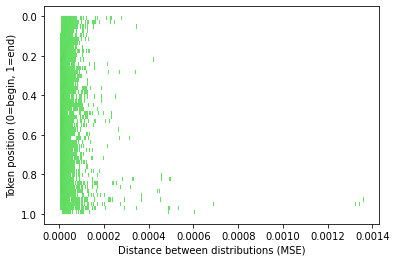

In [73]:
sns.histplot(
    data=df_mse,
    x="mse.mse",
    y="length_percentile",
    color='darkgreen'
)
plt.ylabel("Token position (0=begin, 1=end)")
plt.xlabel("Distance between distributions (MSE)")
# flip vertical axes
plt.gca().invert_yaxis()


Text(0.5, 1.0, 'User Interactions - Human vs Human - Same task, same question')

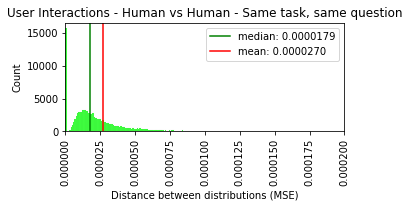

In [74]:
fig, ax = plt.subplots(figsize=(5, 2))
sns.histplot(
    data=df_mse,
    x="mse.mse",
    color='lime',
    ax=ax
)
# plot the median and mean
ax.axvline(x=df_mse["mse.mse"].median(), color="green")
ax.axvline(x=df_mse["mse.mse"].mean(), color="red")
ax.set_xlabel("Distance between distributions (MSE)")
# show legend
ax.legend(
    [
        f"median: {df_mse['mse.mse'].median():.7f}",
        f"mean: {df_mse['mse.mse'].mean():.7f}",
    ]
)
ax.set_xlim(0, 0.0002)
# rotate labels on x axis
plt.xticks(rotation=90)
ax.set_title("User Interactions - Human vs Human - Same task, same question")

### Rank

In [75]:
df_rank = df_human_human_res.copy()
df_rank = explode_column_with_list_of_tuples(
    df_rank, ["rank_list"], new_column_names=["rank", "matrix_line"]
)
# compute the percentile of method length
df_max_length = df_rank.groupby(["source_code"]).agg({"rank.matrix_line": "max"}).reset_index()
df_max_length.rename(columns={"rank.matrix_line": "max_length"}, inplace=True)
df_rank = df_rank.merge(df_max_length, on="source_code")
df_rank["length_percentile"] = df_rank["rank.matrix_line"] / df_rank["max_length"]
df_rank["rank_percentile"] = df_rank["rank.rank"] / df_rank["max_length"]
df_rank.head()

,source_code,human_a,human_b,task_nr_a,task_nr_b,correlation,pvalue,mse_list,rank,rank.rank,rank.matrix_line,max_length,length_percentile,rank_percentile
0,python/tree_Q2.py,UbagU,UbottleU,2,1,0.411864,4.300789e-72,"[[0.0, 0], [0.0, 1], [2.2584783e-05, 2], [0.0,...",NaN,1,0,506,0.000000,0.001976
1,python/tree_Q2.py,UbagU,UbottleU,2,1,0.411864,4.300789e-72,"[[0.0, 0], [0.0, 1], [2.2584783e-05, 2], [0.0,...",NaN,1,1,506,0.001976,0.001976
2,python/tree_Q2.py,UbagU,UbottleU,2,1,0.411864,4.300789e-72,"[[0.0, 0], [0.0, 1], [2.2584783e-05, 2], [0.0,...",NaN,425,2,506,0.003953,0.839921
3,python/tree_Q2.py,UbagU,UbottleU,2,1,0.411864,4.300789e-72,"[[0.0, 0], [0.0, 1], [2.2584783e-05, 2], [0.0,...",NaN,1,3,506,0.005929,0.001976
4,python/tree_Q2.py,UbagU,UbottleU,2,1,0.411864,4.300789e-72,"[[0.0, 0], [0.0, 1], [2.2584783e-05, 2], [0.0,...",NaN,1,4,506,0.007905,0.001976


Unlike MSE, the rank is asymmetric, here we do not care about about which human is the ground truth.


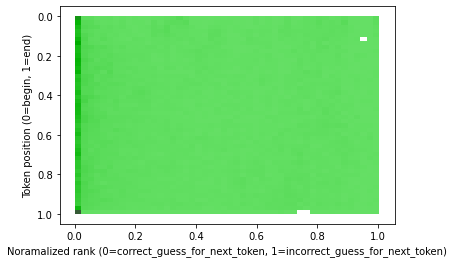

In [76]:
sns.histplot(
    data=df_rank,
    x="rank_percentile",
    y="length_percentile",
    color="darkgreen",
)
plt.ylabel("Token position (0=begin, 1=end)")
plt.xlabel("Noramalized rank (0=correct_guess_for_next_token, 1=incorrect_guess_for_next_token)")
# flip vertical axes
plt.gca().invert_yaxis()
print("Unlike MSE, the rank is asymmetric, here we do not care about about which human is the ground truth.")


Text(0.5, 1.0, 'User Interactions - Human vs Human - Same task, same question')

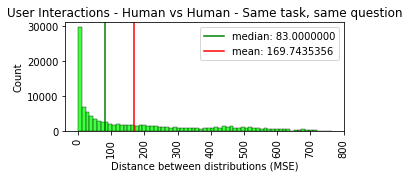

In [77]:

fig, ax = plt.subplots(figsize=(5, 2))
sns.histplot(
    data=df_rank,
    x="rank.rank",
    color='lime',
    ax=ax
)
# plot the median and mean
ax.axvline(x=df_rank["rank.rank"].median(), color="green")
ax.axvline(x=df_rank["rank.rank"].mean(), color="red")
ax.set_xlabel("Distance between distributions (RANK)")
# show legend
ax.legend(
    [
        f"median: {df_rank['rank.rank'].median():.7f}",
        f"mean: {df_rank['rank.rank'].mean():.7f}",
    ]
)
# rotate labels on x axis
plt.xticks(rotation=90)
ax.set_title("User Interactions - Human vs Human - Same task, same question")

# Dataset Stats

In [84]:
# plot the stats of the human dataset (aka which tasks and languages are covered)
records_human_metadata = []
for k, human_meta in all_human_metadata.items():
    new_record = {
        "user_data_id": k,
        "user_name": human_meta["user_name"],
        "task_number": human_meta["task_number"],
        "source_code": human_meta["source_code"],
    }
    records_human_metadata.append(new_record)
df_human_metadata = pd.DataFrame.from_records(records_human_metadata)
df_human_metadata['base_task'] = df_human_metadata['source_code'].apply(
    lambda x: x.split(".")[0].split("/")[-1])
df_human_metadata['base_language'] = df_human_metadata['source_code'].apply(lambda x: x.split(".")[1])
df_human_metadata.head()

,user_data_id,user_name,task_number,source_code,base_task,base_language
0,0480e5,UbagU,2,python/tree_Q2.py,tree_Q2,py
1,08147e,UbeerU,2,python/triangle_Q3.py,triangle_Q3,py
2,09601c,UconsumerU,3,cpp/triangle_Q3.cpp,triangle_Q3,cpp
3,0d7601,UsleepU,0,python/hannoi_Q2.py,hannoi_Q2,py
4,1181b7,UsleepU,1,python/multithread_Q2.py,multithread_Q2,py


\newcommand{\nEyeTrackingParticipants}{23}
\newcommand{\nEyeTrackingSessions}{88}


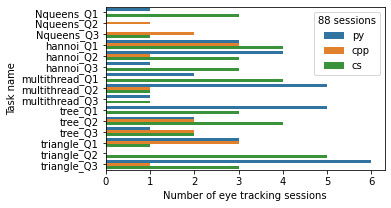

In [97]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.countplot(
    data=df_human_metadata,
    y='base_task',
    hue='base_language',
    # sort the label based on the alphabetical order of the base_task
    order=df_human_metadata['base_task'].value_counts().sort_index().index,
    ax=ax
)
ax.set_ylabel("Task name")
ax.set_xlabel("Number of eye tracking sessions")
# replace the title of the legend with the number of sessions
n_session = len(df_human_metadata)
n_username = len(df_human_metadata['user_name'].unique())
ax.legend(title=f"{n_session} sessions")
fig.savefig(os.path.join(OUT_PAPER_FOLDER, "participants_stats.pdf"))

print("\\newcommand{\\nEyeTrackingParticipants}{" + str(n_username) + "}")
print("\\newcommand{\\nEyeTrackingSessions}{" + str(n_session) + "}")

# Compare Human vs Model

In [34]:
# LOAD ALL DATA
PATH_COMPARISON_FOLDER = f'../data/comparisons/{COMPARISON_FOLDER}/'
available_comparisons = os.listdir(PATH_COMPARISON_FOLDER)
dfs = []
for comparison in available_comparisons:
    dfs.append(pd.read_csv(os.path.join(PATH_COMPARISON_FOLDER, comparison)))
DF = pd.concat(dfs)
DF["comparison_name"].unique()

array(['tl_mse_uniform', 'followup_matrix_line', 'tl_rank_followup',
       'tl_rank_uniform', 'tt_rank_uniform', 'tl_rank_copycat',
       'naive_max_matrix_line', 'uniform_baseline', 'followup_matrix',
       'plain_weights', 'tt_rank_naivemax', 'tt_rank_followup',
       'tt_mse_copycat', 'tl_rank_naivemax', 'tt_rank_copycat',
       'naive_max_matrix', 'tl_mse_copycat'], dtype=object)

In [13]:
# Pick the right Comparison Experiment
from ipywidgets import widgets
from IPython.display import display, clear_output

# crate a dropdown with the widgets of the notebook
def create_dropdown(dropdown_name: str, dropdown_options: List[str]):
    """Create a dropdown widget."""
    dropdown = widgets.Dropdown(
        options=dropdown_options,
        value=dropdown_options[0],
        description=dropdown_name,
        disabled=False,
        layout=widgets.Layout(width='auto')
    )
    return dropdown

# get all the files in the folder
available_comparisons = os.listdir(PATH_COMPARISON_FOLDER)

# instantiate the example dropdown
dropdown = create_dropdown('Comaprison', available_comparisons)

# listen to the dropdown change and load another global df
def on_dropdown_change(change):
    global DF
    global PATH_COMPARISON_FOLDER
    #print(change)
    DF = pd.read_csv(os.path.join(
        PATH_COMPARISON_FOLDER, change.new))
    # clear output except for the dropdown
    clear_output()
    display(change.owner)
    display(DF.head())
    print(f"{change.new} loaded successfully.")

# add the listener to the dropdown
dropdown.observe(on_dropdown_change, names='value')

# display the dropdown
display(dropdown)

Dropdown(description='Comaprison', layout=Layout(width='auto'), options=('tl_mse_uniform.csv', 'followup_matri…

# Vector Level (One attention weight per token)

In [30]:
# define the vector datasets
df_human_vs_model_codegen_same_question_res = DF[
    (DF["comparison_name"].isin(["plain_weights"]))]
# drop columns with null values
df_human_vs_model_codegen_same_question_res = \
    df_human_vs_model_codegen_same_question_res.dropna(axis=1, how="all")

# if the pvalue column doesnt exist, create it and assign constant 0 value
if "pvalue" not in df_human_vs_model_codegen_same_question_res.columns:
    df_human_vs_model_codegen_same_question_res["pvalue"] = 0

vector_comparisons = [
    {
        "short": "human_vs_model_codegen_same_question",
        "long": "Human vs Model - Same question",
        'data': df_human_vs_model_codegen_same_question_res[
            df_human_vs_model_codegen_same_question_res["pvalue"] < 0.05],
        'color': 'lightblue'
    },
    {
        "short": "human_vs_hrr_same_question",
        "long": "Human vs HRR - Same question",
        "data": df_hrr_vs_eye[df_hrr_vs_eye["pvalue"] < 0.05],
        "color": 'aquamarine'
    },
    {
        "short": "human_vs_human_same_question",
        "long": "Human vs Human - Same question",
        "data": df_human_human_res[df_human_human_res["pvalue"] < 0.05],
        'color': 'lime'
    },
    {
        "short": "human_vs_human_same_snippet_any_question",
        "long": "Human vs Human - Same and diff. question",
        "data": df_human_human_macro_task_res[
            df_human_human_macro_task_res["pvalue"] < 0.05],
        'color': 'lightgray'
    },
    {
        "short": "human_vs_human_same_snippet_diff_question",
        "long": "Human vs Human - Diff. question",
        "data": df_human_human_macro_task_diff_question_res[
            df_human_human_macro_task_diff_question_res["pvalue"] < 0.05],
        'color': 'lightgray'
    },
]

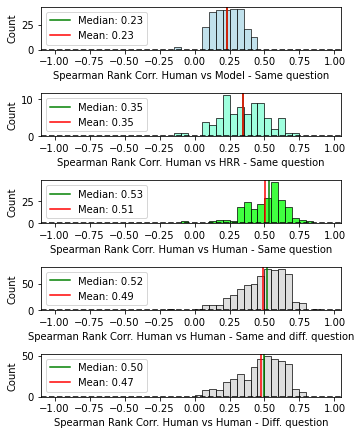

In [31]:
from attwizard.visualizer.eda import plot_histogram_in_parallel

plot_histogram_in_parallel(
    vector_comparisons,
    col_name="correlation",
    common_prefix="Spearman Rank Corr.",
    bins=np.arange(-1, 1, 0.05),
    vertical_zero_line=True, 
    out_path=os.path.join(OUT_PAPER_FOLDER, "vector_agreement.pdf"),
)

# Compare Token-Token Attention Matrices 

In [83]:
matrix_comparisons = [   
    {
        "short": "human_vs_followup",
        "long": "Human vs Followup Att. (CodeGen)",
        'data_tt_mse': DF[(DF["comparison_name"] == "followup_matrix")],
        'data_tl_mse': DF[(DF["comparison_name"] == "followup_matrix_line")],
        "data_tt_rank": DF[(DF["comparison_name"] == "tt_rank_followup")],
        'data_tl_rank': DF[(DF["comparison_name"] == "tl_rank_followup")],
        'color': 'lightcoral',
        'explode_columns': ['mse_list', 'rank_list']
    },
    # {
    #     "short": "human_vs_followupscaled",
    #     "long": "Human vs Followup Att. Scaled (CodeGen)",
    #     'data_tt_mse': DF[(DF["comparison_name"] == "tt_mse_followupscaled")],
    #     'data_tl_mse': DF[(DF["comparison_name"] == "tl_mse_followupscaled")],
    #     "data_tt_rank": DF[(DF["comparison_name"] == "tt_rank_followupscaled")],
    #     'data_tl_rank': DF[(DF["comparison_name"] == "tl_rank_followupscaled")],
    #     'color': 'lightcoral',
    #     'explode_columns': ['mse_list', 'rank_list']
    # },
    {
        "short": "human_vs_max",
        "long": "Human vs Max Att. (CodeGen)",
        "data_tt_mse": DF[(DF["comparison_name"] == "naive_max_matrix")],
        'data_tl_mse': DF[(DF["comparison_name"] == "naive_max_matrix_line")],
        "data_tt_rank": DF[(DF["comparison_name"] == "tt_rank_naivemax")],
        'data_tl_rank': DF[(DF["comparison_name"] == "tl_rank_naivemax")],
        "color": 'lightcoral',
        'explode_columns': ['mse_list', 'rank_list']
    },
    {
        "short": "human_vs_uniform",
        "long": "Human vs Uniform (no model)",
        "data_tt_mse": DF[(DF["comparison_name"] == "uniform_baseline")],
        'data_tl_mse': DF[(DF["comparison_name"] == "tl_mse_uniform")],
        "data_tt_rank": DF[(DF["comparison_name"] == "tt_rank_uniform")],
        'data_tl_rank': DF[(DF["comparison_name"] == "tl_rank_uniform")],
        'color': 'skyblue',
        'explode_columns': ['mse_list', 'rank_list']
    },
    {
        "short": "human_vs_copycat",
        "long": "Human vs Copycat (no model)",
        "data_tt_mse": DF[(DF["comparison_name"] == "tt_mse_copycat")],
        'data_tl_mse': DF[(DF["comparison_name"] == "tl_mse_copycat")],
        "data_tt_rank": DF[(DF["comparison_name"] == "tt_rank_copycat")],
        'data_tl_rank': DF[(DF["comparison_name"] == "tl_rank_copycat")],
        'color': 'skyblue',
        'explode_columns': ['mse_list', 'rank_list']
    },
    {
        "short": 'human_vs_human',
        'long': 'Human vs Human',
        'data_tt_mse': df_human_human_res,
        'data_tl_mse': df_human_human_line_res,
        'data_tt_rank': df_human_human_res,
        'data_tl_rank': df_human_human_line_res,
        'color': 'lime',
        'explode_columns': ['mse_list', 'rank_list']
    }
]


In [86]:
df_human_human_res.iloc[0]['human_a']

'UbagU'

In [87]:
df_human_human_res.columns

Index(['source_code', 'human_a', 'human_b', 'task_nr_a', 'task_nr_b',
       'correlation', 'pvalue', 'mse_list', 'rank_list'],
      dtype='object')

In [81]:
APPLY_WEIGHTS = True

# LOAD THE TOKEN INFORMATION
HUMAN_ATT_ON_CODEGEN_TOKENS_METADATA_FODLER = '../data/eye_tracking_attention/eye_v10/att_weights_Salesforce_codegen-16B-multi/metadata'
codegen_tokens = read_data_in_parallel(
    base_folder=HUMAN_ATT_ON_CODEGEN_TOKENS_METADATA_FODLER,
    file_type_extension='.json',
    read_function=load_json_file
)
all_tokens = [v for k, v in codegen_tokens.items()]
# flattent the list
all_tokens = [item for sublist in all_tokens for item in sublist]
df_tokens = pd.DataFrame.from_records(all_tokens)
# compute the total time spent in each session to normalize the weights
df_total_times = df_tokens.groupby('id').agg({'w': 'sum'}).reset_index()
df_total_times.rename(columns={'w': 'total_time'}, inplace=True)
# join the two tables and compute the percentage of total time with column w and column total_time
df_tokens_w_time = df_tokens.merge(df_total_times, on='id')
df_tokens_w_time['n_replicas_abs'] = df_tokens_w_time['w'].astype(int)
df_tokens_w_time['perc_time'] = df_tokens_w_time['w'] / df_tokens_w_time['total_time']
df_tokens_w_time['n_replicas_perc'] = df_tokens_w_time['perc_time'].apply(
    lambda x: round(x * 1000))
# rename the columns to join
df_tokens_w_time.rename(columns={
    'id': 'input_human_filestem',
    'i': 'token_index'}, inplace=True)

n of data read:  92


### Experiment adding token information

In [46]:
from attwizard.analysis_pass.data_helper import explode_column_with_list_of_tuples

df_comparison = DF[(DF["comparison_name"] == "followup_matrix")]
df_comp_single_session = df_comparison[df_comparison['input_human_filestem'] == '0480e5']
print(df_comp_single_session.shape)
# explode the column mse_list
df_comp_single_session = explode_column_with_list_of_tuples(
    df_comp_single_session.iloc[:1], ['mse_list'], new_column_names=['value', 'token_index'])
# rename mse.token_index to token_index
df_comp_single_session.rename(columns={'mse.token_index': 'token_index'}, inplace=True)
# add the df_tokens_w_time to the df_comparison, keep the same records in the df_comp_single_session
df_comp_single_session = df_comp_single_session.merge(
    df_tokens_w_time, on=['input_human_filestem', 'token_index'], how='left')
df_comp_single_session.head() 

(3, 32)


,comparison_name,comparison_function,source_code,user_name,task_number,input_human_filestem,input_machine_filestem,comparison_type,mse,time_ts_sec,...,s,c,l,t,w,model,total_time,n_replicas_abs,perc_time,n_replicas_perc
0,followup_matrix,mse_line_by_line,tree_Q2.py,UbagU,2,0480e5,tree_Q2.py_0_Salesforce_codegen-16B-multi,matrix,NaN,1.663181e+09,...,0,0,0,#,0.0,Salesforce/codegen-16B-multi,6607.23048,0,0.0,0
1,followup_matrix,mse_line_by_line,tree_Q2.py,UbagU,2,0480e5,tree_Q2.py_0_Salesforce_codegen-16B-multi,matrix,NaN,1.663181e+09,...,1,1,0,********************************,0.0,Salesforce/codegen-16B-multi,6607.23048,0,0.0,0
2,followup_matrix,mse_line_by_line,tree_Q2.py,UbagU,2,0480e5,tree_Q2.py_0_Salesforce_codegen-16B-multi,matrix,NaN,1.663181e+09,...,34,34,0,********************************,0.0,Salesforce/codegen-16B-multi,6607.23048,0,0.0,0
3,followup_matrix,mse_line_by_line,tree_Q2.py,UbagU,2,0480e5,tree_Q2.py_0_Salesforce_codegen-16B-multi,matrix,NaN,1.663181e+09,...,66,66,0,********,0.0,Salesforce/codegen-16B-multi,6607.23048,0,0.0,0
4,followup_matrix,mse_line_by_line,tree_Q2.py,UbagU,2,0480e5,tree_Q2.py_0_Salesforce_codegen-16B-multi,matrix,NaN,1.663181e+09,...,74,74,0,***,0.0,Salesforce/codegen-16B-multi,6607.23048,0,0.0,0


In [47]:
len(df_comp_single_session['mse.value'])

507

In [52]:
df_inspect = df_comp_single_session[['mse.value', 'w', 't', 'n_replicas_abs']]
# get data where the mse.value is -1
df_inspect = df_inspect[df_inspect['mse.value'] == -1]
df_inspect

,mse.value,w,t,n_replicas_abs
0,-1.0,0.0,#,0
1,-1.0,0.0,********************************,0
2,-1.0,0.0,********************************,0
3,-1.0,0.0,********,0
4,-1.0,0.0,***,0
...,...,...,...,...
429,-1.0,0.0,Index,0
435,-1.0,0.0,=,0
444,-1.0,0.0,),0
463,-1.0,0.0,),0


In [50]:
df_inspect['w'].unique()

array([0.])

In [47]:
df_comp_single_session['input_machine_filestem'].unique()

array(['tree_Q2.py_0_Salesforce_codegen-16B-multi'], dtype=object)

In [54]:
# replicate the rows for n_replicas_abs
df_to_plot = df_comp_single_session.loc[
    np.repeat(df_comp_single_session.index.values, df_comp_single_session['n_replicas_perc'])]
df_to_plot.head(20)

,comparison_name,comparison_function,source_code,user_name,task_number,input_human_filestem,input_machine_filestem,comparison_type,mse,time_ts_sec,...,s,c,l,t,w,model,total_time,n_replicas_abs,perc_time,n_replicas_perc
18,followup_matrix,mse_line_by_line,tree_Q2.py,UbagU,2,0480e5,tree_Q2.py_0_Salesforce_codegen-16B-multi,matrix,NaN,1.663181e+09,...,133,54,2,data,4.22560,Salesforce/codegen-16B-multi,6607.23048,4,0.000640,1
19,followup_matrix,mse_line_by_line,tree_Q2.py,UbagU,2,0480e5,tree_Q2.py_0_Salesforce_codegen-16B-multi,matrix,NaN,1.663181e+09,...,138,59,2,structure,5.43944,Salesforce/codegen-16B-multi,6607.23048,5,0.000823,1
30,followup_matrix,mse_line_by_line,tree_Q2.py,UbagU,2,0480e5,tree_Q2.py_0_Salesforce_codegen-16B-multi,matrix,NaN,1.663181e+09,...,175,10,7,init,3.91407,Salesforce/codegen-16B-multi,6607.23048,3,0.000592,1
33,followup_matrix,mse_line_by_line,tree_Q2.py,UbagU,2,0480e5,tree_Q2.py_0_Salesforce_codegen-16B-multi,matrix,NaN,1.663181e+09,...,182,17,7,self,6.99803,Salesforce/codegen-16B-multi,6607.23048,6,0.001059,1
35,followup_matrix,mse_line_by_line,tree_Q2.py,UbagU,2,0480e5,tree_Q2.py_0_Salesforce_codegen-16B-multi,matrix,NaN,1.663181e+09,...,187,22,7,data,5.18845,Salesforce/codegen-16B-multi,6607.23048,5,0.000785,1
38,followup_matrix,mse_line_by_line,tree_Q2.py,UbagU,2,0480e5,tree_Q2.py_0_Salesforce_codegen-16B-multi,matrix,NaN,1.663181e+09,...,196,0,9,,4.95899,Salesforce/codegen-16B-multi,6607.23048,4,0.000751,1
39,followup_matrix,mse_line_by_line,tree_Q2.py,UbagU,2,0480e5,tree_Q2.py_0_Salesforce_codegen-16B-multi,matrix,NaN,1.663181e+09,...,204,8,9,self,9.01659,Salesforce/codegen-16B-multi,6607.23048,9,0.001365,1
40,followup_matrix,mse_line_by_line,tree_Q2.py,UbagU,2,0480e5,tree_Q2.py_0_Salesforce_codegen-16B-multi,matrix,NaN,1.663181e+09,...,208,12,9,.,3.38574,Salesforce/codegen-16B-multi,6607.23048,3,0.000512,1
41,followup_matrix,mse_line_by_line,tree_Q2.py,UbagU,2,0480e5,tree_Q2.py_0_Salesforce_codegen-16B-multi,matrix,NaN,1.663181e+09,...,209,13,9,data,8.58397,Salesforce/codegen-16B-multi,6607.23048,8,0.001299,1
42,followup_matrix,mse_line_by_line,tree_Q2.py,UbagU,2,0480e5,tree_Q2.py_0_Salesforce_codegen-16B-multi,matrix,NaN,1.663181e+09,...,213,17,9,=,4.25098,Salesforce/codegen-16B-multi,6607.23048,4,0.000643,1


<AxesSubplot:xlabel='mse.value', ylabel='Count'>

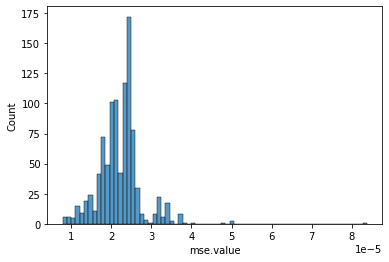

In [55]:
sns.histplot(
    # drop nan values in columns mse.value
    data=df_to_plot.dropna(subset=['mse.value']).reset_index(),
    x='mse.value',
)

### Process Data and Plot

In [84]:

from attwizard.analysis_pass.data_helper import explode_column_with_list_of_tuples
from copy import deepcopy
data_to_explode = [
    "data_tt", "data_tl"
]

# explode columns
for info in matrix_comparisons:
    print(info["short"])
    for data_attribute in data_to_explode:
        for col_to_explode in info.get('explode_columns', []):
            short_col = col_to_explode.replace("_list", "")
            print(f'col_to_explode: {col_to_explode}')
            df = info[f'{data_attribute}_{short_col}']
            new_column_names = ["value", "token_index"]
            df = explode_column_with_list_of_tuples(
                df, [col_to_explode], new_column_names=new_column_names)                
            # drop all the rows with -1 in the col_short
            df = df[df[f'{short_col}.value'] != -1]


            # enrich the dataset with the token position and replicate the 
            # records depending on how much time the user spent on that starting
            # token
            df_tokens_w_time_copy = df_tokens_w_time
            df_tokens_w_time_copy = df_tokens_w_time_copy.rename(columns={
                'token_index': f'{short_col}.token_index'})
            if 'human_a' in  df.columns:
                df = df.rename(columns={
                    'human_a': 'input_human_filestem'})
            df = df.merge(
                df_tokens_w_time_copy, 
                on=['input_human_filestem', f'{short_col}.token_index'], 
                how='left')
            df = df.loc[
                np.repeat(df.index.values, df['n_replicas_perc'])]
            info[f'{data_attribute}_{short_col}'] = df

human_vs_followup
col_to_explode: mse_list
short_col: mse
Index(['s', 'mse.token_index', 'c', 'l', 't', 'w', 'model',
       'input_human_filestem', 'total_time', 'n_replicas_abs', 'perc_time',
       'n_replicas_perc'],
      dtype='object')
col_to_explode: rank_list
short_col: rank
Index(['s', 'rank.token_index', 'c', 'l', 't', 'w', 'model',
       'input_human_filestem', 'total_time', 'n_replicas_abs', 'perc_time',
       'n_replicas_perc'],
      dtype='object')
col_to_explode: mse_list
short_col: mse
Index(['s', 'mse.token_index', 'c', 'l', 't', 'w', 'model',
       'input_human_filestem', 'total_time', 'n_replicas_abs', 'perc_time',
       'n_replicas_perc'],
      dtype='object')
col_to_explode: rank_list
short_col: rank
Index(['s', 'rank.token_index', 'c', 'l', 't', 'w', 'model',
       'input_human_filestem', 'total_time', 'n_replicas_abs', 'perc_time',
       'n_replicas_perc'],
      dtype='object')
human_vs_max
col_to_explode: mse_list
short_col: mse
Index(['s', 'mse.token_

KeyError: 'input_human_filestem'

In [37]:
matrix_comparisons[0].keys()

dict_keys(['short', 'long', 'data_tt_mse', 'data_tl_mse', 'data_tt_rank', 'data_tl_rank', 'color', 'explode_columns'])

### MSE

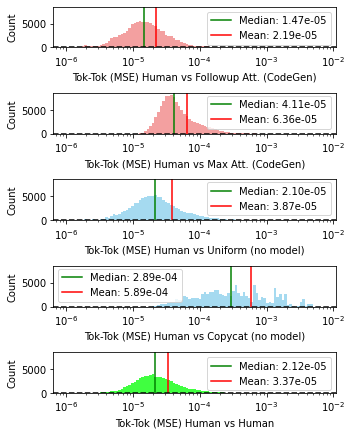

In [38]:
plot_histogram_in_parallel(
    matrix_comparisons,
    col_name="mse.value",
    common_prefix="Tok-Tok (MSE)",
    #bins=np.arange(0, 0.0002, 0.00001),
    bins=np.logspace(np.log10(10e-7), np.log10(0.007), 100),
    scale="log",
    fmt=".2e",
    sharey=True, 
    vertical_zero_line=True, 
    data_attribute="data_tt_mse",
    out_path=os.path.join(OUT_PAPER_FOLDER, "tt_mse_histogram.pdf"),
)

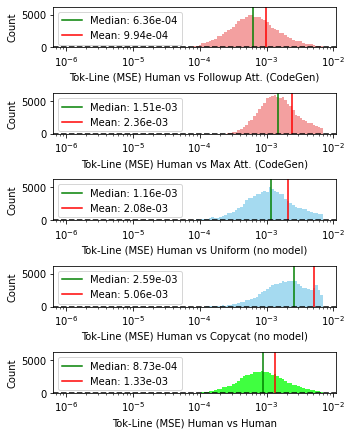

In [39]:
plot_histogram_in_parallel(
    matrix_comparisons,
    col_name="mse.value",
    common_prefix="Tok-Line (MSE)",
    #bins=np.arange(0, 0.0002, 0.00001),
    bins=np.logspace(np.log10(10e-7), np.log10(0.007), 100),
    scale="log",
    fmt=".2e",
    sharey=True, 
    vertical_zero_line=True, 
    data_attribute="data_tl_mse",
    out_path=os.path.join(OUT_PAPER_FOLDER, "tl_mse_histogram.pdf"),
)

### RANK

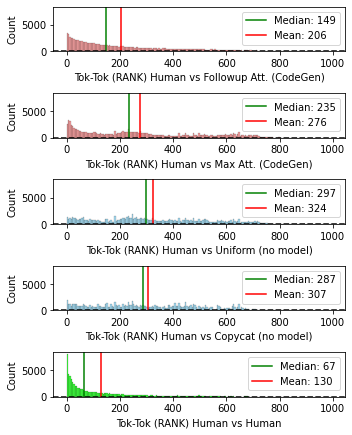

In [40]:
plot_histogram_in_parallel(
    matrix_comparisons,
    col_name="rank.value",
    common_prefix="Tok-Tok (RANK)",
    bins=np.arange(0, 1000, 5),
    fmt=".0f",
    sharey=True, 
    vertical_zero_line=True, 
    data_attribute="data_tt_rank",
    out_path=os.path.join(OUT_PAPER_FOLDER, "tt_rank_histogram.pdf"),
)

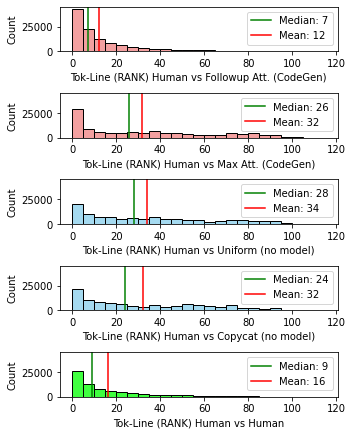

In [41]:
plot_histogram_in_parallel(
    matrix_comparisons,
    col_name="rank.value",
    common_prefix="Tok-Line (RANK)",
    bins=np.arange(0, 120, 5),
    fmt=".0f",
    sharey=True, 
    #vertical_zero_line=True, 
    #width=20, 
    #height_per_histogram=10,
    data_attribute="data_tl_rank",
    out_path=os.path.join(OUT_PAPER_FOLDER, "tl_rank_histogram.pdf"),
)

# Ranking Comparisons

In [27]:
COMPARISON_FOLDER = 'cmp_v03'
# LOAD ALL DATA
PATH_COMPARISON_FOLDER = f'../data/comparisons/{COMPARISON_FOLDER}/'
available_comparisons = os.listdir(PATH_COMPARISON_FOLDER)
dfs = []
for comparison in available_comparisons:
    dfs.append(pd.read_csv(os.path.join(PATH_COMPARISON_FOLDER, comparison)))
DF = pd.concat(dfs)
DF["comparison_name"].unique()

array(['tl_top3_uniform', 'tt_spearman_uniform', 'tt_top10_uniform',
       'tt_top3_naivemax', 'tl_top10_uniform', 'tl_spearman_followup',
       'tl_top10_followup', 'tt_top10_followup', 'tt_spearman_copycat',
       'tl_spearman_naivemax', 'tt_top3_followup', 'tt_perfmatch_copycat',
       'tl_perfmatch_followup', 'tl_perfmatch_naivemax',
       'tt_perfmatch_naivemax', 'tl_perfmatch_uniform',
       'tt_perfmatch_uniform', 'tl_spearman_uniform',
       'tt_perfmatch_followup', 'tt_top3_copycat', 'tl_top3_followup',
       'tl_spearman_copycat', 'tl_perfmatch_copycat', 'tt_top10_naivemax',
       'tl_top10_naivemax', 'tt_top3_uniform', 'tl_top3_copycat',
       'tl_top10_copycat', 'tl_top3_naivemax', 'tt_spearman_naivemax',
       'tt_spearman_followup', 'tt_top10_copycat'], dtype=object)

In [29]:
# rename column top_k_overlap to top_k_list
DF = DF.rename(columns={"top_3_overlap": "top_3_list", "top_10_overlap": "top_10_list"})

In [32]:

matrix_comparisons = [   
    {
        "short": "human_vs_followup",
        "long": "Human vs Followup Att. (CodeGen)",
        'data_tt_top_3': DF[(DF["comparison_name"] == "tt_top3_followup")],
        'data_tl_top_3': DF[(DF["comparison_name"] == "tl_top3_followup")],
        'color': 'lightcoral',
        'explode_columns': ['top_3_list']
    },
    {
        "short": "human_vs_max",
        "long": "Human vs Max Att. (CodeGen)",
        "data_tt_top_3": DF[(DF["comparison_name"] == "tt_top3_naivemax")],
        "data_tl_top_3": DF[(DF["comparison_name"] == "tl_top3_naivemax")],
        "color": 'lightcoral',
        'explode_columns': ['top_3_list']
    },
    {
        "short": "human_vs_uniform",
        "long": "Human vs Uniform (no model)",
        "data_tt_top_3": DF[(DF["comparison_name"] == "tt_top3_uniform")],
        "data_tl_top_3": DF[(DF["comparison_name"] == "tl_top3_uniform")],
        'color': 'skyblue',
        'explode_columns': ['top_3_list']
    },
    {
        "short": "human_vs_copycat",
        "long": "Human vs Copycat (no model)",
        "data_tt_top_3": DF[(DF["comparison_name"] == "tt_top3_copycat")],
        "data_tl_top_3": DF[(DF["comparison_name"] == "tl_top3_copycat")],
        'color': 'skyblue',
        'explode_columns': ['top_3_list']
    },
    # {
    #     "short": 'human_vs_human',
    #     'long': 'Human vs Human',
    #     'data_tt_top_3': df_human_human_res,
    #     'data_tl_top_3': df_human_human_line_res,
    #     'color': 'lime',
    #     'explode_columns': ['top_3_list']
    # }
]

from attwizard.analysis_pass.data_helper import explode_column_with_list_of_tuples

data_to_explode = [
    "data_tt", "data_tl"
]

# explode columns
for info in matrix_comparisons:
    for data_attribute in data_to_explode:
        for col_to_explode in info.get('explode_columns', []):
            short_col = col_to_explode.replace("_list", "")
            print(f'col_to_explode: {col_to_explode}')
            df = info[f'{data_attribute}_{short_col}']
            new_column_names = ["value", "token_index"]
            df = explode_column_with_list_of_tuples(
                df, [col_to_explode], new_column_names=new_column_names)
            # drop all the rows with -1 in the col_short
            df = df[df[f'{short_col}.value'] != -1]
            info[f'{data_attribute}_{short_col}'] = df

col_to_explode: top_3_list
col_to_explode: top_3_list
col_to_explode: top_3_list
col_to_explode: top_3_list
col_to_explode: top_3_list
col_to_explode: top_3_list
col_to_explode: top_3_list
col_to_explode: top_3_list


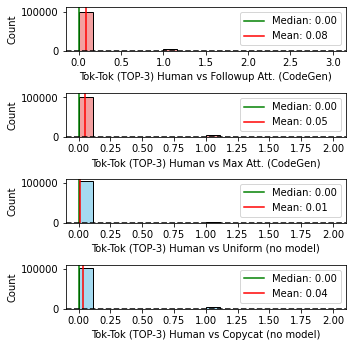

In [33]:
plot_histogram_in_parallel(
    matrix_comparisons,
    col_name="top_3.value",
    common_prefix="Tok-Tok (TOP-3)",
    sharey=True, 
    vertical_zero_line=True, 
    data_attribute="data_tt_top_3",
    out_path=os.path.join(OUT_PAPER_FOLDER, "tt_top3_histogram.pdf"),
)

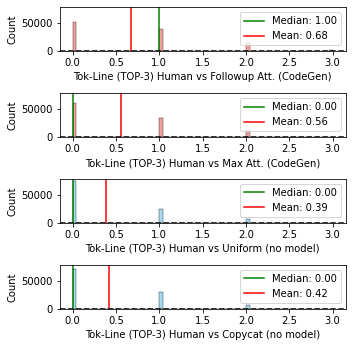

In [34]:
plot_histogram_in_parallel(
    matrix_comparisons,
    col_name="top_3.value",
    common_prefix="Tok-Line (TOP-3)",
    sharey=True, 
    vertical_zero_line=True, 
    data_attribute="data_tl_top_3",
    out_path=os.path.join(OUT_PAPER_FOLDER, "tl_top3_histogram.pdf"),
)

## Sperrman Rank by line

In [36]:

matrix_comparisons = [   
    {
        "short": "human_vs_followup",
        "long": "Human vs Followup Att. (CodeGen)",
        'data_tt_spearman_res': DF[(DF["comparison_name"] == "tt_spearman_followup")],
        'data_tl_spearman_res': DF[(DF["comparison_name"] == "tl_spearman_followup")],
        'color': 'lightcoral',
        'explode_columns': ['spearman_res_list']
    },
    {
        "short": "human_vs_max",
        "long": "Human vs Max Att. (CodeGen)",
        "data_tt_spearman_res": DF[(DF["comparison_name"] == "tt_spearman_naivemax")],
        "data_tl_spearman_res": DF[(DF["comparison_name"] == "tl_spearman_naivemax")],
        "color": 'lightcoral',
        'explode_columns': ['spearman_res_list']
    },
    {
        "short": "human_vs_uniform",
        "long": "Human vs Uniform (no model)",
        "data_tt_spearman_res": DF[(DF["comparison_name"] == "tt_spearman_uniform")],
        "data_tl_spearman_res": DF[(DF["comparison_name"] == "tl_spearman_uniform")],
        'color': 'skyblue',
        'explode_columns': ['spearman_res_list']
    },
    {
        "short": "human_vs_copycat",
        "long": "Human vs Copycat (no model)",
        "data_tt_spearman_res": DF[(DF["comparison_name"] == "tt_spearman_copycat")],
        "data_tl_spearman_res": DF[(DF["comparison_name"] == "tl_spearman_copycat")],
        'color': 'skyblue',
        'explode_columns': ['spearman_res_list']
    },
    # {
    #     "short": 'human_vs_human',
    #     'long': 'Human vs Human',
    #     'data_tt_spearman_res': df_human_human_res,
    #     'data_tl_spearman_res': df_human_human_line_res,
    #     'color': 'lime',
    #     'explode_columns': ['spearman_res_list']
    # }
]

from attwizard.analysis_pass.data_helper import explode_column_with_list_of_tuples

data_to_explode = [
    "data_tt", "data_tl"
]

# explode columns
for info in matrix_comparisons:
    for data_attribute in data_to_explode:
        for col_to_explode in info.get('explode_columns', []):
            short_col = col_to_explode.replace("_list", "")
            print(f'col_to_explode: {col_to_explode}')
            df = info[f'{data_attribute}_{short_col}']
            new_column_names = ["value", "pvalue", "token_index"]
            df = explode_column_with_list_of_tuples(
                df, [col_to_explode], new_column_names=new_column_names)
            # drop all the rows with -1 in the col_short
            df = df[df[f'{short_col}.value'] != -1]
            info[f'{data_attribute}_{short_col}'] = df

col_to_explode: spearman_res_list
col_to_explode: spearman_res_list
col_to_explode: spearman_res_list
col_to_explode: spearman_res_list
col_to_explode: spearman_res_list
col_to_explode: spearman_res_list
col_to_explode: spearman_res_list
col_to_explode: spearman_res_list


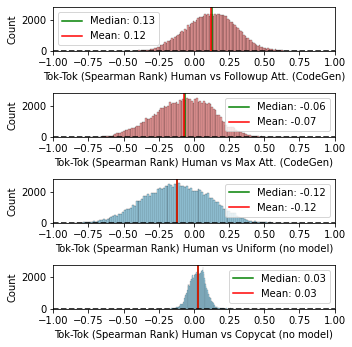

In [39]:
plot_histogram_in_parallel(
    matrix_comparisons,
    col_name="spearman_res.value",
    common_prefix="Tok-Tok (Spearman Rank)",
    sharey=True, 
    xlim=(-1, 1),
    vertical_zero_line=True, 
    data_attribute="data_tt_spearman_res",
    out_path=os.path.join(OUT_PAPER_FOLDER, "tt_spearman_histogram.pdf"),
)

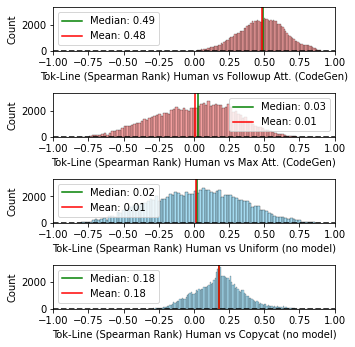

In [40]:
plot_histogram_in_parallel(
    matrix_comparisons,
    col_name="spearman_res.value",
    common_prefix="Tok-Line (Spearman Rank)",
    sharey=True, 
    xlim=(-1, 1),
    vertical_zero_line=True, 
    data_attribute="data_tl_spearman_res",
    out_path=os.path.join(OUT_PAPER_FOLDER, "tl_spearman_histogram.pdf"),
)

In [42]:
raise Exception("stop")

Exception: stop

## Plot data

In [8]:
import ast

def explode_numeric_columns(df_selection, columns_to_explode):
    """Explode the numerical columns passed."""
    tmp_df_selction = df_selection
    df_selection = tmp_df_selction.copy()
    del tmp_df_selction

    def transform_to_list(x):
        try:
            res = ast.literal_eval(x)
        except ValueError as e:
            print(e)
            print(x)
        return res

    # explode all the lists
    for col_list in columns_to_explode:
        col_short = col_list.replace("_list", "")
        # convert the col_list to a proper python list 
        df_selection.loc[:, (col_list)] = df_selection.apply(
            lambda row: transform_to_list(row[col_list]), axis=1)
        df_selection = df_selection.explode(col_list)
        df_selection.reset_index(drop=True, inplace=True)
        # rename col_list to col_short
        df_selection.rename(columns={col_list: col_short}, inplace=True)
        # convert col_short to numeric column
        df_selection[col_short] = pd.to_numeric(df_selection[col_short])
    return df_selection



def explode_column_with_list_of_tuples(
        df_selection, 
        columns_to_explode: List[str], 
        new_column_names: List[str]):
    """Explode the columns passed which must be list of tuples.

    Note that the columns_to_explode must be contain "_list" in the name.

    and example could be the following coming from corelation and pvalue 
    of a test:
    [[0.2, 0.0007], [0.23, 0.0003], [0.223, 0.9]]
    this will explode each element of the list in a new row, and create two 
    columns with the name expressed in the new_column_names parameter (e.g.
    columns_to_explode = "spearman_res_list"
    new_column_names = ["corelation", "pvalue"]
    it will produce two new columns:
    spearman_res.corelation and spearman_res.pvalue    
    """
    tmp_df_selction = df_selection
    df_selection = tmp_df_selction.copy()
    del tmp_df_selction

    def transform_to_list(x):
        try:
            res = ast.literal_eval(x)
        except ValueError as e:
            print(e)
            print(x)
        return res

    # explode all the lists
    for col_list in columns_to_explode:
        col_short = col_list.replace("_list", "")
        # convert the col_list to a proper python list 
        df_selection.loc[:, (col_list)] = df_selection.apply(
            lambda row: transform_to_list(row[col_list]), axis=1)
        df_selection = df_selection.explode(col_list)
        df_selection.reset_index(drop=True, inplace=True)
        # rename col_list to col_short
        df_selection.rename(columns={col_list: col_short}, inplace=True)
        # convert the short column with a pair to a list
        
        if new_column_names == None:
            new_column_names = ["el_0", "el_1"]
        for i, element_name in enumerate(new_column_names):
            df_selection[f"{col_short}.{element_name}"] = df_selection.apply(
                lambda row: transform_to_list(str(row[col_short]))[i], 
                axis=1
            )        

        df_selection[col_short] = df_selection[col_short].str.split(",") 

    return df_selection

### Spearman Rank by Line - Followup and Naive Max

Multiply everything times the weight (sum up to one) and get the density plot.

Try with mean, instead of max.
Highed layers should count more, weighted mean.
competitors
- navive mean
- weigthed mean
- us

(-1.0, 1.0)

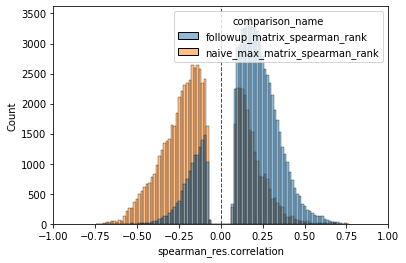

In [8]:
df_selection = DF[
    (DF["comparison_name"].isin(["followup_matrix_spearman_rank", "naive_max_matrix_spearman_rank"]))]
columns_to_explode = ["spearman_res_list"]
  
df_selection = explode_column_with_list_of_tuples(
    df_selection, columns_to_explode, new_column_names=["correlation", "pvalue"])

# filter pvalue lower than 0.05
df_selection = df_selection[df_selection["spearman_res.pvalue"] < 0.05]

sns.histplot(
    data=df_selection,
    x="spearman_res.correlation",
    hue="comparison_name",
    kde=False,
)
plt.axvline(x=0, color="red", linewidth=1, linestyle="--")
plt.xlim(-1, 1)


# Token-Token

### MSE by Line - Followup and Naive Max

(0.0, 0.0002)

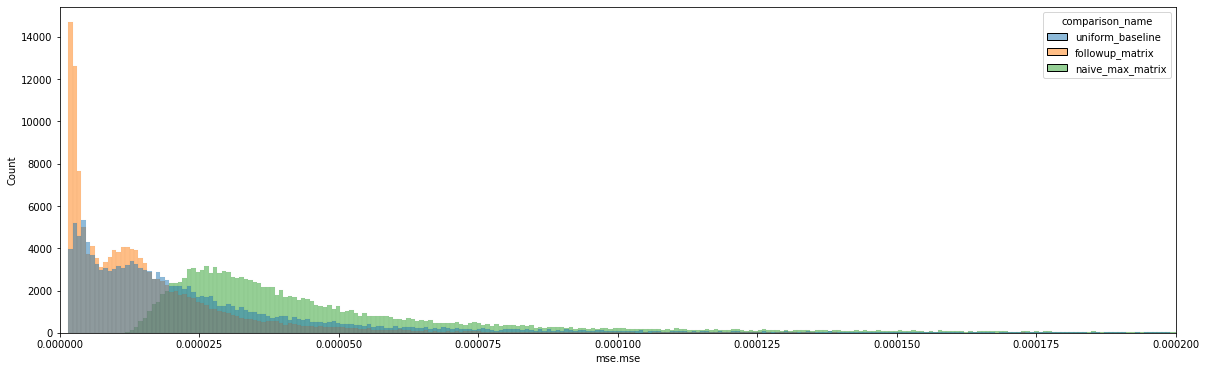

In [10]:
df_selection = DF[
    (DF["comparison_name"].isin([
        "followup_matrix", "naive_max_matrix",
        "uniform_baseline", 
        #"rollout_matrix", 
        #"transitive_matrix_right", 
        #"transitive_matrix_left"
    ]))]
columns_to_explode = ["mse_list"]
  
df_selection = explode_column_with_list_of_tuples(
    df_selection, columns_to_explode, new_column_names=["mse", "matrix_line"])

fig, ax = plt.subplots(figsize=(20, 6))
sns.histplot(
    data=df_selection,
    x="mse.mse",
    hue="comparison_name",
    kde=False,
    ax=ax
)
plt.xlim(0, .0002)

TODO:
Example with one matrix of uniform vs followup.
inspect one low MSE datapoint.

Maybe the difference is on EOL.
- human do not look at EOL (or look weakly at EOL)
- model looks at EOL (strongly)
- uniform looks at EOL  (weakly)

On a line by line we should have this effect less, so uniform should become worst.


<AxesSubplot:xlabel='mse.mse', ylabel='Count'>

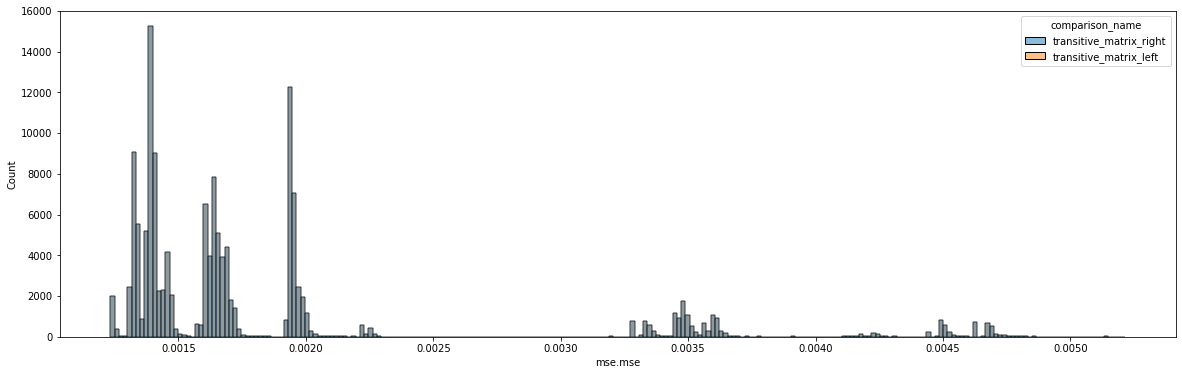

In [12]:
df_selection = DF[
    (DF["comparison_name"].isin([
        #"followup_matrix", "naive_max_matrix",
        #"uniform_baseline", 
        #"rollout_matrix", 
        "transitive_matrix_right", 
        "transitive_matrix_left"
    ]))]
columns_to_explode = ["mse_list"]
  
df_selection = explode_column_with_list_of_tuples(
    df_selection, columns_to_explode, new_column_names=["mse", "matrix_line"])


fig, ax = plt.subplots(figsize=(20, 6))
sns.histplot(
    data=df_selection,
    x="mse.mse",
    hue="comparison_name",
    kde=False,
    ax=ax
)
#plt.xlim(0, .0002)

compute the rollout matrix from attention matrix > A
we could compute the rollout from the uniform matrix > B

VISUAL INSPEcTIONS

we could normalized A with B (kind of differential appraoch)

### JSD by Line - Followup and Naive Max

(0.0, 1.0)

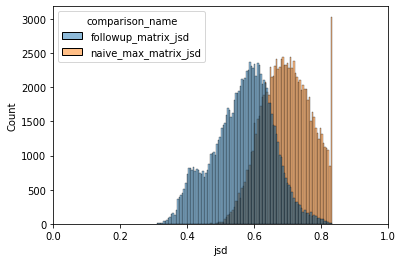

In [13]:
df_selection = DF[
    (DF["comparison_name"].isin(["followup_matrix_jsd", "naive_max_matrix_jsd"]))]
columns_to_explode = ["jsd_list"]
  
df_selection = explode_numeric_columns(df_selection, columns_to_explode)

sns.histplot(
    data=df_selection,
    x="jsd",
    hue="comparison_name",
    kde=False,
)
plt.xlim(0, 1)

### Mean Reciprocal Rank - Followup and Naive Max

(0.0, 1.0)

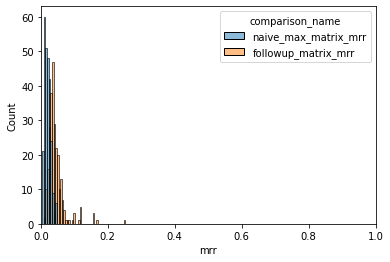

In [14]:
df_selection = DF[
    (DF["comparison_name"].isin(["followup_matrix_mrr", "naive_max_matrix_mrr"]))]
# reset index
df_selection.reset_index(drop=True, inplace=True)

sns.histplot(
    data=df_selection,
    x="mrr",
    hue="comparison_name",
    kde=False,
)
plt.xlim(0, 1)

### Harmonic Rank - Followup vs Naive Max

<AxesSubplot:xlabel='harmonic_rank', ylabel='Count'>

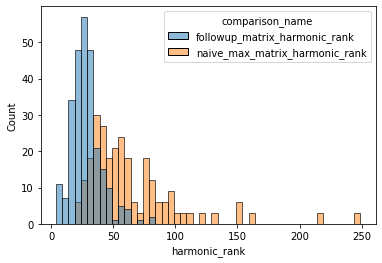

In [15]:
df_selection = DF[
    (DF["comparison_name"].isin(["followup_matrix_harmonic_rank", "naive_max_matrix_harmonic_rank"]))]
# reset index
df_selection.reset_index(drop=True, inplace=True)

sns.histplot(
    data=df_selection,
    x="harmonic_rank",
    hue="comparison_name",
    kde=False,
    binwidth=5,
)

check the example which give low harmonic rank

### Harmonic Rank Backward

(0.0, 70.0)

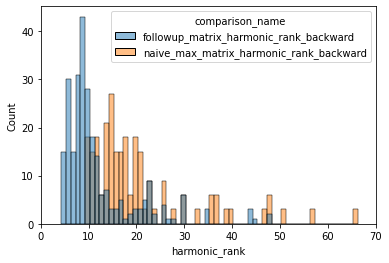

In [17]:
df_selection = DF[
    (DF["comparison_name"].isin(["followup_matrix_harmonic_rank_backward", "naive_max_matrix_harmonic_rank_backward"]))]
# reset index
df_selection.reset_index(drop=True, inplace=True)

sns.histplot(
    data=df_selection,
    x="harmonic_rank",
    hue="comparison_name",
    kde=False,
    binwidth=1,
)
plt.xlim(0, 70)

### Without spaces and end of line

(0.0, 70.0)

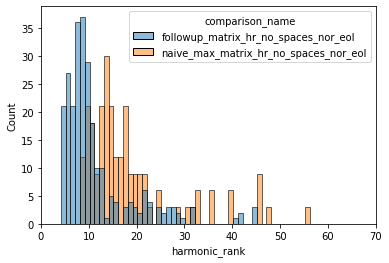

In [19]:
df_selection = DF[
    (DF["comparison_name"].isin([
        'followup_matrix_hr_no_spaces_nor_eol',
        'naive_max_matrix_hr_no_spaces_nor_eol'
]))]
# reset index
df_selection.reset_index(drop=True, inplace=True)

sns.histplot(
    data=df_selection,
    x="harmonic_rank",
    hue="comparison_name",
    kde=False,
    binwidth=1,
)
plt.xlim(0, 70)

inspect very good and bad cases for both

In [14]:
from attwizard.analysis_pass.transformation_functions import remove_specific_tokens

In [18]:
# create a random matrix
a = np.random.rand(4, 4)
print(a)

b = np.random.rand(4, 4)
print(b)

metadata = {"tokens_prompt": ["a", "S", "c", "S"]}

a2, b2 = remove_specific_tokens(
    a, b, metadata, metadata, tokens_to_remove=["S"])

print(a2)
print(b2)


[[0.65416165 0.45038978 0.23121611 0.38739874]
 [0.77257753 0.22459145 0.01905458 0.87654087]
 [0.60472306 0.94788096 0.8148646  0.70753923]
 [0.73068188 0.40185821 0.44366507 0.38749187]]
[[0.59630265 0.33128388 0.11361831 0.6751235 ]
 [0.23932821 0.41285985 0.50502623 0.90833373]
 [0.14027766 0.20964386 0.92786478 0.54233233]
 [0.91624312 0.84036169 0.08322402 0.14913922]]
[[0.65416165 0.23121611]
 [0.60472306 0.8148646 ]]
[[0.59630265 0.11361831]
 [0.14027766 0.92786478]]


### Spearman Rank Correlation

32


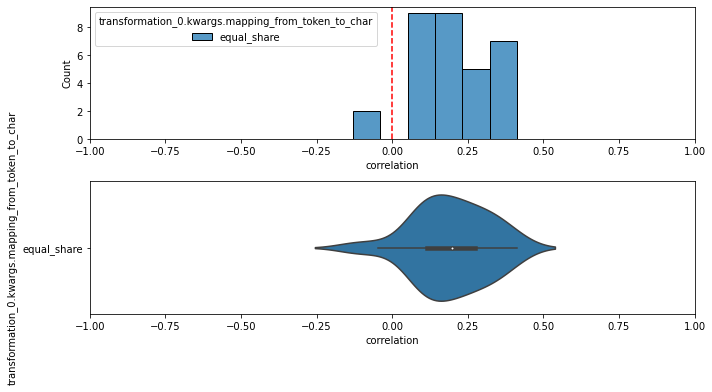

In [56]:
# keep only spearman_rank
df_selection = DF[
    (DF["comparison_name"] == "plain_weights")
    & (DF["pvalue"] <= 0.05)]
print(len(df_selection))
visualize_corr_vs(
    df_selection,
    col_to_inspect="transformation_0.kwargs.mapping_from_token_to_char",
    var_of_interest="correlation"
)

# Token-Line

## MSE

<AxesSubplot:xlabel='mse.mse', ylabel='Count'>

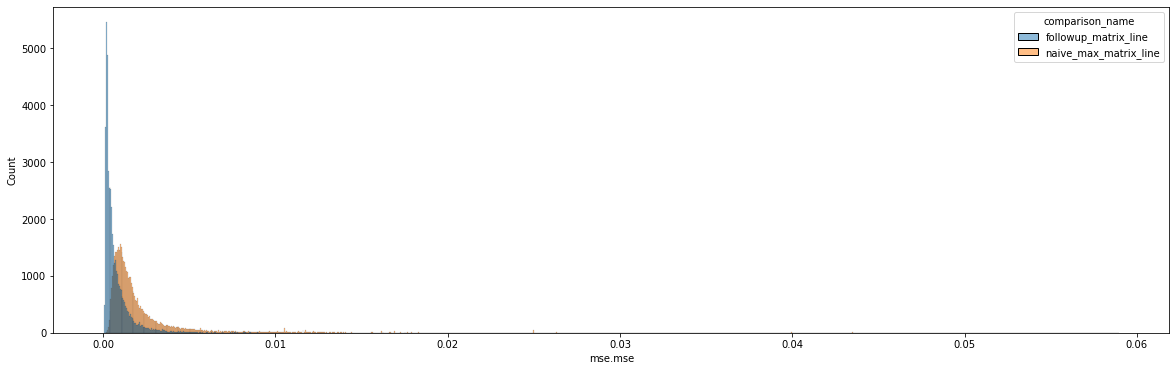

In [17]:
df_selection = DF[
    (DF["comparison_name"].isin([
        "followup_matrix_line", "naive_max_matrix_line",
    ]))]
columns_to_explode = ["mse_list"]
  
df_selection = explode_column_with_list_of_tuples(
    df_selection, columns_to_explode, new_column_names=["mse", "matrix_line"])

def is_first_pediction(df):
    return df["input_machine_filestem"].str.contains("_0_")

df_selection = df_selection[is_first_pediction(df_selection)]

fig, ax = plt.subplots(figsize=(20, 6))
sns.histplot(
    data=df_selection,
    x="mse.mse",
    hue="comparison_name",
    kde=False,
    ax=ax
)

## Harmonic Rank

<AxesSubplot:xlabel='harmonic_rank', ylabel='Count'>

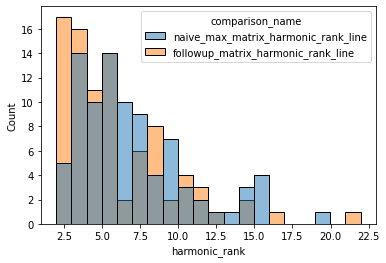

In [18]:
df_selection = DF[
    (DF["comparison_name"].isin(["followup_matrix_harmonic_rank_line", "naive_max_matrix_harmonic_rank_line"]))]
# reset index
df_selection.reset_index(drop=True, inplace=True)
def is_first_pediction(df):
    return df["input_machine_filestem"].str.contains("_0_")

df_selection = df_selection[is_first_pediction(df_selection)]

sns.histplot(
    data=df_selection,
    x="harmonic_rank",
    hue="comparison_name",
    kde=False,
    binwidth=1,
)

# Read Human Data

In [22]:
HUMAN_FOLDER = f"../data/eye_tracking_attention/{HUMAN_EXPERIMENT}"

In [24]:
# HUMAN - METADATA
all_human_metadata = read_data_in_parallel(
    base_folder=os.path.join(HUMAN_FOLDER, "metadata"),
    file_type_extension=".json",
    read_function=load_json_file)
all_human_metadata.keys()

n of data read:  88


dict_keys(['0480e5', '08147e', '09601c', '0d7601', '1181b7', '155d45', '161f21', '1d5b6a', '2babb5', '300bd1', '38606b', '3b0e57', '3b39e2', '3d9b54', '3e474f', '4022a9', '403482', '43e18c', '448383', '44d4f6', '44e060', '4a262b', '4a5896', '4c260d', '500208', '5403f5', '545804', '56f44e', '5a70af', '5bf279', '653139', '6695fa', '675fc1', '6831ef', '7740fd', '7a600a', '81a0b9', '842f7a', '88a0ee', '88a31c', '93d2e1', '95024d', '97a19f', '98a211', '9bcda0', '9e5778', '9fd0c1', 'a4a47a', 'ab1e99', 'ab3a90', 'aecca4', 'afc047', 'b0172f', 'b3a349', 'b595bc', 'b5c173', 'b6cb6e', 'b7971a', 'b7c85e', 'b84310', 'b8a651', 'b93c2f', 'bda0b1', 'be9283', 'bf760e', 'c35fdf', 'c46e6d', 'c46f82', 'c6d8ff', 'c7ca22', 'cbdc06', 'd27bf6', 'd3a4b4', 'd401e5', 'd41dd8', 'd485dd', 'dc14ad', 'debcce', 'df2957', 'df7ddd', 'e0495f', 'e33aac', 'e63ddf', 'e84aa9', 'f4bbec', 'f5e35b', 'f7b913', 'f936ca'])

In [23]:
# HUMAN - DATA
all_human_data = read_data_in_parallel(
    base_folder=os.path.join(HUMAN_FOLDER, "att_weights"),
    file_type_extension=".npy",
    read_function=np.load)
all_human_data.keys()

n of data read:  88


dict_keys(['0480e5', '08147e', '09601c', '0d7601', '1181b7', '155d45', '161f21', '1d5b6a', '2babb5', '300bd1', '38606b', '3b0e57', '3b39e2', '3d9b54', '3e474f', '4022a9', '403482', '43e18c', '448383', '44d4f6', '44e060', '4a262b', '4a5896', '4c260d', '500208', '5403f5', '545804', '56f44e', '5a70af', '5bf279', '653139', '6695fa', '675fc1', '6831ef', '7740fd', '7a600a', '81a0b9', '842f7a', '88a0ee', '88a31c', '93d2e1', '95024d', '97a19f', '98a211', '9bcda0', '9e5778', '9fd0c1', 'a4a47a', 'ab1e99', 'ab3a90', 'aecca4', 'afc047', 'b0172f', 'b3a349', 'b595bc', 'b5c173', 'b6cb6e', 'b7971a', 'b7c85e', 'b84310', 'b8a651', 'b93c2f', 'bda0b1', 'be9283', 'bf760e', 'c35fdf', 'c46e6d', 'c46f82', 'c6d8ff', 'c7ca22', 'cbdc06', 'd27bf6', 'd3a4b4', 'd401e5', 'd41dd8', 'd485dd', 'dc14ad', 'debcce', 'df2957', 'df7ddd', 'e0495f', 'e33aac', 'e63ddf', 'e84aa9', 'f4bbec', 'f5e35b', 'f7b913', 'f936ca'])

In [7]:
# HUMAN - USER INTERACTION DATA
all_human_data_followup = read_data_in_parallel(
    base_folder=os.path.join(HUMAN_FOLDER, "decay_0.1", "data_followup_tokens_tokens_model"),
    file_type_extension=".npy",
    read_function=np.load)
all_human_data_followup.keys()

n of data read:  38


dict_keys(['0480e5', '08147e', '09601c', '161f21', '1d5b6a', '300bd1', '38606b', '3b0e57', '3d9b54', '3e474f', '4022a9', '403482', '448383', '44e060', '56f44e', '5a70af', '6695fa', '675fc1', '6831ef', '7740fd', '7a600a', '81a0b9', '88a0ee', '9fd0c1', 'a4a47a', 'ab1e99', 'afc047', 'b0172f', 'b5c173', 'bda0b1', 'c35fdf', 'c46f82', 'c7ca22', 'd401e5', 'd41dd8', 'df2957', 'e0495f', 'e33aac'])

# Read Machine Data - CodeGen

In [8]:
MACHINE_FOLDER = f"../data/model_output/{MACHINE_EXPERIMENT}"

In [21]:
# METADATA
all_machine_metadata = read_data_in_parallel(
    base_folder=os.path.join(MACHINE_FOLDER, "metadata"),
    file_type_extension=".json",
    read_function=load_json_file)
all_machine_metadata = {
   "_".join( k.split("_")[:2]): v for k, v in all_machine_metadata.items()}
all_machine_metadata.keys()

n of data read:  45


dict_keys(['tree_Q1.cpp', 'hannoi_Q1.cs', 'tree_Q3.cs', 'scheduler_Q1.py', 'hannoi_Q1.cpp', 'triangle_Q1.cs', 'Nqueens_Q1.py', 'Nqueens_Q2.py', 'tree_Q3.py', 'Nqueens_Q3.py', 'countprimes_Q3.cpp', 'hannoi_Q3.cpp', 'scheduler_Q3.cs', 'Nqueens_Q2.cpp', 'scheduler_Q2.cs', 'scheduler_Q1.cs', 'hannoi_Q3.py', 'scheduler_Q3.py', 'triangle_Q2.py', 'triangle_Q3.cpp', 'tree_Q3.cpp', 'countprimes_Q1.cpp', 'scheduler_Q2.py', 'tree_Q1.cs', 'tree_Q2.cpp', 'triangle_Q2.cs', 'hannoi_Q1.py', 'Nqueens_Q3.cs', 'hannoi_Q2.py', 'triangle_Q1.cpp', 'triangle_Q3.cs', 'tree_Q2.cs', 'Nqueens_Q1.cs', 'countprimes_Q2.cpp', 'triangle_Q1.py', 'tree_Q1.py', 'Nqueens_Q1.cpp', 'hannoi_Q3.cs', 'Nqueens_Q3.cpp', 'triangle_Q3.py', 'hannoi_Q2.cs', 'triangle_Q2.cpp', 'hannoi_Q2.cpp', 'Nqueens_Q2.cs', 'tree_Q2.py'])

In [10]:
# DATA - vector
all_machine_data_vector = read_data_in_parallel(
    base_folder=os.path.join(MACHINE_FOLDER, "vector_naive_max_plus_mean_of_followers"),
    file_type_extension=".npy",
    read_function=np.load)
all_machine_data_vector = {
    "_".join( k.split("_")[:2]): v for k, v in all_machine_data_vector.items()}
all_machine_data_vector.keys()

n of data read:  45


dict_keys(['Nqueens_Q1.cpp', 'Nqueens_Q1.cs', 'Nqueens_Q1.py', 'Nqueens_Q2.cpp', 'Nqueens_Q2.cs', 'Nqueens_Q2.py', 'Nqueens_Q3.cpp', 'Nqueens_Q3.cs', 'Nqueens_Q3.py', 'countprimes_Q1.cpp', 'countprimes_Q2.cpp', 'countprimes_Q3.cpp', 'hannoi_Q1.cpp', 'hannoi_Q1.cs', 'hannoi_Q1.py', 'hannoi_Q2.cpp', 'hannoi_Q2.cs', 'hannoi_Q2.py', 'hannoi_Q3.cpp', 'hannoi_Q3.cs', 'hannoi_Q3.py', 'scheduler_Q1.cs', 'scheduler_Q1.py', 'scheduler_Q2.cs', 'scheduler_Q2.py', 'scheduler_Q3.cs', 'scheduler_Q3.py', 'tree_Q1.cpp', 'tree_Q1.cs', 'tree_Q1.py', 'tree_Q2.cpp', 'tree_Q2.cs', 'tree_Q2.py', 'tree_Q3.cpp', 'tree_Q3.cs', 'tree_Q3.py', 'triangle_Q1.cpp', 'triangle_Q1.cs', 'triangle_Q1.py', 'triangle_Q2.cpp', 'triangle_Q2.cs', 'triangle_Q2.py', 'triangle_Q3.cpp', 'triangle_Q3.cs', 'triangle_Q3.py'])

In [11]:
# DATA - followup matrix
all_machine_data_followup = read_data_in_parallel(
    base_folder=os.path.join(MACHINE_FOLDER, "followup"),
    file_type_extension=".npy",
    read_function=np.load)
all_machine_data_followup = {
    "_".join( k.split("_")[:2]): v for k, v in all_machine_data_followup.items()}
all_machine_data_followup.keys()

n of data read:  45


dict_keys(['Nqueens_Q1.cpp', 'Nqueens_Q1.cs', 'Nqueens_Q1.py', 'Nqueens_Q2.cpp', 'Nqueens_Q2.cs', 'Nqueens_Q2.py', 'Nqueens_Q3.cpp', 'Nqueens_Q3.cs', 'Nqueens_Q3.py', 'countprimes_Q1.cpp', 'countprimes_Q2.cpp', 'countprimes_Q3.cpp', 'hannoi_Q1.cpp', 'hannoi_Q1.cs', 'hannoi_Q1.py', 'hannoi_Q2.cpp', 'hannoi_Q2.cs', 'hannoi_Q2.py', 'hannoi_Q3.cpp', 'hannoi_Q3.cs', 'hannoi_Q3.py', 'scheduler_Q1.cs', 'scheduler_Q1.py', 'scheduler_Q2.cs', 'scheduler_Q2.py', 'scheduler_Q3.cs', 'scheduler_Q3.py', 'tree_Q1.cpp', 'tree_Q1.cs', 'tree_Q1.py', 'tree_Q2.cpp', 'tree_Q2.cs', 'tree_Q2.py', 'tree_Q3.cpp', 'tree_Q3.cs', 'tree_Q3.py', 'triangle_Q1.cpp', 'triangle_Q1.cs', 'triangle_Q1.py', 'triangle_Q2.cpp', 'triangle_Q2.cs', 'triangle_Q2.py', 'triangle_Q3.cpp', 'triangle_Q3.cs', 'triangle_Q3.py'])

In [12]:
# DATA - naive max
all_machine_data_max = read_data_in_parallel(
    base_folder=os.path.join(MACHINE_FOLDER, "naive_max"),
    file_type_extension=".npy",
    read_function=np.load)
all_machine_data_max = {
    "_".join( k.split("_")[:2]): v for k, v in all_machine_data_max.items()}
all_machine_data_max.keys()

n of data read:  45


dict_keys(['Nqueens_Q1.cpp', 'Nqueens_Q1.cs', 'Nqueens_Q1.py', 'Nqueens_Q2.cpp', 'Nqueens_Q2.cs', 'Nqueens_Q2.py', 'Nqueens_Q3.cpp', 'Nqueens_Q3.cs', 'Nqueens_Q3.py', 'countprimes_Q1.cpp', 'countprimes_Q2.cpp', 'countprimes_Q3.cpp', 'hannoi_Q1.cpp', 'hannoi_Q1.cs', 'hannoi_Q1.py', 'hannoi_Q2.cpp', 'hannoi_Q2.cs', 'hannoi_Q2.py', 'hannoi_Q3.cpp', 'hannoi_Q3.cs', 'hannoi_Q3.py', 'scheduler_Q1.cs', 'scheduler_Q1.py', 'scheduler_Q2.cs', 'scheduler_Q2.py', 'scheduler_Q3.cs', 'scheduler_Q3.py', 'tree_Q1.cpp', 'tree_Q1.cs', 'tree_Q1.py', 'tree_Q2.cpp', 'tree_Q2.cs', 'tree_Q2.py', 'tree_Q3.cpp', 'tree_Q3.cs', 'tree_Q3.py', 'triangle_Q1.cpp', 'triangle_Q1.cs', 'triangle_Q1.py', 'triangle_Q2.cpp', 'triangle_Q2.cs', 'triangle_Q2.py', 'triangle_Q3.cpp', 'triangle_Q3.cs', 'triangle_Q3.py'])

In [13]:
machine_matrix_data = {
    "naive_max": all_machine_data_max,
    "followup": all_machine_data_followup,
}

# Debug Metadata Consistency

In [14]:
for unique_data_id in all_human_metadata.keys():
    try:
        assert len(all_human_metadata[unique_data_id]["raw_text"]) == len(all_human_data[unique_data_id]), "not matching"
    except Exception as e:
        print(unique_data_id, e)

# Compare Vectors

In [15]:
COMPARISONS = [
    {
        "short": "spr",
        "comparison_name": "Spearman Rank Corr.",
        "type": "stat_test",
        "subtype": "correlation",
        "compare_prob": False,
        "min_value": -1,
        "max_value": 1,
        "compare_function": spearmanr
    },
    {
        "short": "ks",
        "comparison_name": "Kolmogorov-Smirnov Test",
        "type": "stat_test",
        "subtype": None,
        "compare_prob": True,
        "min_value": 0,
        "max_value": 1,
        "compare_function": kstest
    },
    {
        "short": "jsd",
        "comparison_name": "Jensen-Shannon Divergence",
        "type": "distance",
        "subtype": None,
        "compare_prob": True,
        "min_value": 0,
        "max_value": None,
        "compare_function": jensenshannon
    }
]

In [16]:
all_records_results = []

for compare_config in COMPARISONS:
    compare_fn = compare_config["compare_function"]
    compare_type = compare_config["type"]
    compare_subtype = compare_config["subtype"]
    compare_prob = compare_config["compare_prob"]

    for unique_data_id in tqdm(all_human_data.keys()):
        c_human_vector = all_human_data[unique_data_id]
        c_human_metadata = all_human_metadata[unique_data_id]

        #print(c_human_metadata["user_name"], " - ", c_human_metadata["source_code"])
        c_file_name = os.path.basename(c_human_metadata["source_code"])
        
        try:
            c_machine_vector = all_machine_data_vector[c_file_name]
            c_machine_metadata = all_machine_metadata[c_file_name]
        except KeyError as e:
            print(f"{c_file_name} not found in att_matrices")
            continue
        
        #mapping_from_token_to_char = "equal_share"
        for mapping_from_token_to_char in ["equal_share", "replication"]:
            #print("=" * 80)

            model_att_weigth_vector_char = map_to_char_level(
                tokens=c_machine_metadata["tokens_prompt"],
                att_weights=list(c_machine_vector),
                raw_text=c_machine_metadata["text_prompt"],
                distribution_fn=mapping_from_token_to_char,
                special_char_mapping={
                    "Ġ": ' ',
                    "Ċ": '\n',
                }
            )
            # COMPUTE CORRELATION
            # since the model predicts after the `# Answer:` token 
            # also the relevant human tokens do not include anything after that
            # we remove everything after the last `:` character
            original_prompt = c_human_metadata["raw_text"]
            pos_end_of_answer_token = original_prompt.rfind("Answer") + len("Answer")
            human_vector = c_human_vector[:pos_end_of_answer_token]
            model_vector = model_att_weigth_vector_char[:pos_end_of_answer_token]
            
            if (len(human_vector) < len(model_vector)):
                #print("=" * 80)
                #print("H: ", c_human_metadata["raw_text"][:])
                #print("=" * 80)
                #print("M: ",c_machine_metadata["text_prompt"][:])
                break

            if compare_prob:
                #print("Convert to probabilities.")
                # convert vector to probabilities
                human_vector = human_vector / np.sum(human_vector)
                machine_vector = model_vector / np.sum(model_vector)
            try:   
                #print(
                #    f"Comparing (char-level): " +
                #    f"Human ({len(human_vector)}) vs " +
                #    f"Machine ({len(model_vector)}) (with {compare_fn})")
                res = compare_fn(human_vector, model_vector)
                if compare_type == "stat_test":
                    if compare_subtype == "correlation":
                        comp_res = {
                            "correlation": res.correlation,
                            "pvalue": res.pvalue,
                        }
                    else:
                        comp_res = {
                            "statistic": res.statistic,
                            "pvalue": res.pvalue,
                        }
                elif compare_type == "distance":
                    comp_res = {
                        "distance": res
                    }
            except ValueError as e:
                print(e)
                #print("H: n_chars: ", len(c_human_metadata["raw_text"]))
                #print(c_human_metadata["raw_text"][:])
                #print("M: n_chars: ", len(c_machine_metadata["text_prompt"]))
                #print("M: n_char_tokens: ", len(model_att_weigth_vector_char))
                #print(c_machine_metadata["text_prompt"][:])

                #print("H: ", len(c_human_metadata["raw_text"]), " -> ", len(human_vector))
                #print("M: ", len(c_machine_metadata["text_prompt"]), " -> ", len(model_vector))
                #continue
                raise e
            new_record = {
                "source_code": c_file_name,
                "user_name": c_human_metadata["user_name"],
                "task_number": c_human_metadata["task_number"],
                "mapping_from_token_to_char": mapping_from_token_to_char,
                **compare_config,
                **comp_res
            }
            all_records_results.append(new_record)


df_res = pd.DataFrame.from_records(all_records_results)
df_res.head()

 58%|█████▊    | 22/38 [00:00<00:00, 91.27it/s] 

multithread_Q1.py not found in att_matrices


100%|██████████| 38/38 [00:00<00:00, 103.93it/s]


multithread_Q2.cpp not found in att_matrices
multithread_Q1.py not found in att_matrices
multithread_Q2.py not found in att_matrices


  0%|          | 0/38 [00:00<?, ?it/s]

multithread_Q1.py not found in att_matrices


100%|██████████| 38/38 [00:00<00:00, 97.36it/s] 


multithread_Q2.cpp not found in att_matrices
multithread_Q1.py not found in att_matrices
multithread_Q2.py not found in att_matrices


  0%|          | 0/38 [00:00<?, ?it/s]

multithread_Q1.py not found in att_matrices


 68%|██████▊   | 26/38 [00:00<00:00, 118.10it/s]

multithread_Q2.cpp not found in att_matrices


100%|██████████| 38/38 [00:00<00:00, 126.10it/s]

multithread_Q1.py not found in att_matrices
multithread_Q2.py not found in att_matrices


,source_code,user_name,task_number,mapping_from_token_to_char,short,comparison_name,type,subtype,compare_prob,min_value,max_value,compare_function,correlation,pvalue,statistic,distance
0,tree_Q2.py,UbagU,2,equal_share,spr,Spearman Rank Corr.,stat_test,correlation,False,-1,1.0,<function spearmanr at 0x7f24b8528a60>,-0.016131,0.501809,NaN,NaN
1,tree_Q2.py,UbagU,2,replication,spr,Spearman Rank Corr.,stat_test,correlation,False,-1,1.0,<function spearmanr at 0x7f24b8528a60>,-0.102723,0.000018,NaN,NaN
2,triangle_Q3.py,UbeerU,2,equal_share,spr,Spearman Rank Corr.,stat_test,correlation,False,-1,1.0,<function spearmanr at 0x7f24b8528a60>,0.087519,0.001422,NaN,NaN
3,triangle_Q3.py,UbeerU,2,replication,spr,Spearman Rank Corr.,stat_test,correlation,False,-1,1.0,<function spearmanr at 0x7f24b8528a60>,0.059395,0.030564,NaN,NaN
4,triangle_Q3.cpp,UconsumerU,3,equal_share,spr,Spearman Rank Corr.,stat_test,correlation,False,-1,1.0,<function spearmanr at 0x7f24b8528a60>,0.060801,0.010533,NaN,NaN


## Q: Do Human and Model have identical distribution?
**KS TEST**

In [17]:
df = df_res[df_res["short"] == "ks"]
# count how many have a pvalue <= 0.05
df_legit_res = df[df["pvalue"] <= 0.05]
perc_sign_diff = (len(df_legit_res) / len(df)) * 100
print(f"{len(df_legit_res)} out of {len(df)} (perc. = {perc_sign_diff:.2f}) "
      f"are significantly different (have a pvalue <= 0.05)")

68 out of 68 (perc. = 100.00) are significantly different (have a pvalue <= 0.05)


## Q: How do their relative rank agree?
**Spearman Rank Correlation**

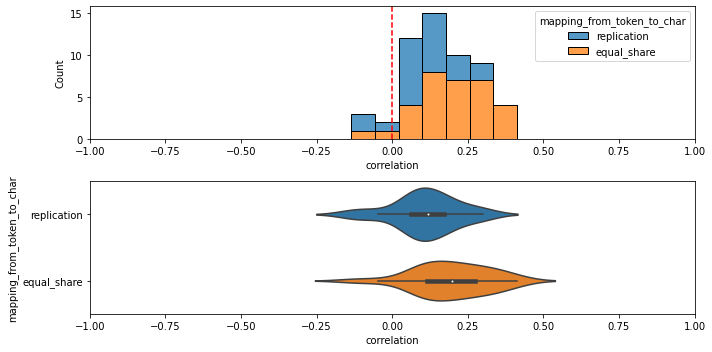

In [18]:
df_legit_res = df_res[df_res["pvalue"] <= 0.05]
visualize_corr_vs(
    df_legit_res,
    col_to_inspect="mapping_from_token_to_char",
)

## Q: How far are the two ditributions?
**Jensen-Shannon divergence**

(0.0, 1.0)

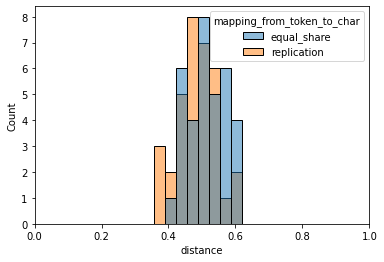

In [19]:
df = df_res[df_res["short"] == "jsd"]
sns.histplot(
    data=df,
    x="distance",
    hue="mapping_from_token_to_char"
)
plt.xlim(0, 1)

# Compare User-Interactions

In [80]:
def normalize_matrix_by_line(matrix: np.ndarray) -> np.ndarray:
    """Normalize the matrix by line."""
    summation_vector = matrix.sum(axis=1, keepdims=True)
    # replace nan with 1
    summation_vector = np.nan_to_num(summation_vector, nan=1)
    res = matrix / summation_vector
    return np.nan_to_num(res, nan=0)

In [82]:
COMPARISONS_MATRIX = [
    {
        "short": "mse",
        "comparison_name": "Mean Square Error",
        "type": "loss",
        "normalization": normalize_matrix_by_line,
        "compare_function": torch.nn.MSELoss()
    },
]

In [92]:
records = []

for processing_mode in machine_matrix_data.keys():
    c_all_machine_matrices = machine_matrix_data[processing_mode]

    for compare_config in COMPARISONS_MATRIX:
        compare_fn = compare_config["compare_function"]
        compare_type = compare_config["type"]
        compare_norm = compare_config["normalization"]

        for target_user_task in tqdm(all_human_data_followup.keys()):
            matrix_human = all_human_data_followup[target_user_task]
            metadata_human = all_human_metadata[target_user_task]
            metadata_human_matrix = all_human_data_followup[target_user_task]
            # remove the last token since it is a normal new line
            #matrix_human = matrix_human[:-1, :-1]
            print(f"Human data ({target_user_task}): {matrix_human.shape}")
            # get corresponding machine matrix
            source_code_filename = metadata_human['source_code'].split('/')[-1]
            try:
                matrix_machine = c_all_machine_matrices[source_code_filename]
            except KeyError as e:
                print(f"\tNo machine data for {source_code_filename}. Skipping.")
                continue
            # note that the machine has more tokens than the human
            # because it includes the predicted text
            # thus consider only the prompt tokens
            metadata_machine = all_machine_metadata[source_code_filename]
            n_tokens = len(metadata_machine['tokens_prompt'])
            matrix_machine = matrix_machine[:n_tokens, :n_tokens]
            print(f"Corresponding machine data ({source_code_filename}): {matrix_machine.shape}")
            # normalize by line (so to have probabilities)
            matrix_human = matrix_human[:n_tokens, :n_tokens]
            matrix_human_normalized = normalize_matrix_by_line(matrix_human)
            matrix_machine_normalized = normalize_matrix_by_line(matrix_machine)
            # compute the loss
            for i in tqdm(range(n_tokens)):
                if compare_type == "loss":
                    current_loss = compare_fn(
                        torch.from_numpy(matrix_human_normalized)[i, :], 
                        torch.from_numpy(matrix_machine_normalized)[i, :]
                    )
                    comp_res = {
                        "loss": current_loss.item(),
                        "weight": matrix_human[i, :].sum()
                    }

                records.append({
                    "target_user_task": target_user_task,
                    "source_code_filename": source_code_filename,
                    "processing_mode": processing_mode,
                    **comp_res,
                    **compare_config
                })

df_raw_comparisons = pd.DataFrame.from_records(records)


  0%|          | 0/38 [00:00<?, ?it/s]/tmp/ipykernel_418094/1082744252.py:6: RuntimeWarning: invalid value encountered in divide
  res = matrix / summation_vector


Human data (0480e5): (507, 507)
Corresponding machine data (tree_Q2.py): (507, 507)


100%|██████████| 507/507 [00:00<00:00, 20642.74it/s]


Human data (08147e): (518, 518)
Corresponding machine data (triangle_Q3.py): (518, 518)


100%|██████████| 518/518 [00:00<00:00, 20543.79it/s]


Human data (09601c): (692, 692)
Corresponding machine data (triangle_Q3.cpp): (690, 690)


  8%|▊         | 3/38 [00:00<00:01, 29.02it/s]

Human data (161f21): (768, 768)
	No machine data for multithread_Q1.py. Skipping.
Human data (1d5b6a): (283, 283)
Corresponding machine data (hannoi_Q2.cpp): (281, 281)


100%|██████████| 281/281 [00:00<00:00, 21212.71it/s]


Human data (300bd1): (292, 292)
Corresponding machine data (hannoi_Q1.cpp): (290, 290)


100%|██████████| 290/290 [00:00<00:00, 21430.43it/s]


Human data (38606b): (611, 611)
Corresponding machine data (tree_Q3.cpp): (609, 609)


100%|██████████| 609/609 [00:00<00:00, 20443.48it/s]


Human data (3b0e57): (693, 693)
Corresponding machine data (triangle_Q1.cpp): (691, 691)


 21%|██        | 8/38 [00:00<00:00, 38.07it/s]

Human data (3d9b54): (216, 216)
Corresponding machine data (hannoi_Q2.py): (216, 216)


100%|██████████| 216/216 [00:00<00:00, 20523.98it/s]


Human data (3e474f): (450, 450)
Corresponding machine data (Nqueens_Q1.py): (450, 450)


100%|██████████| 450/450 [00:00<00:00, 18579.51it/s]


Human data (4022a9): (283, 283)
Corresponding machine data (hannoi_Q2.cs): (281, 281)


100%|██████████| 281/281 [00:00<00:00, 20549.92it/s]


Human data (403482): (599, 599)
Corresponding machine data (tree_Q2.cpp): (597, 597)


100%|██████████| 597/597 [00:00<00:00, 20632.65it/s]


Human data (448383): (611, 611)
Corresponding machine data (tree_Q3.cpp): (609, 609)


 34%|███▍      | 13/38 [00:00<00:00, 37.35it/s]

Human data (44e060): (519, 519)
Corresponding machine data (triangle_Q1.py): (519, 519)


100%|██████████| 519/519 [00:00<00:00, 20443.49it/s]


Human data (56f44e): (635, 635)
Corresponding machine data (Nqueens_Q3.cs): (633, 633)


100%|██████████| 633/633 [00:00<00:00, 19182.10it/s]


Human data (5a70af): (507, 507)
Corresponding machine data (tree_Q2.py): (507, 507)


100%|██████████| 507/507 [00:00<00:00, 20845.09it/s]


Human data (6695fa): (307, 307)
Corresponding machine data (hannoi_Q3.cs): (304, 304)


 45%|████▍     | 17/38 [00:00<00:00, 35.75it/s]

Human data (675fc1): (519, 519)
Corresponding machine data (triangle_Q1.py): (519, 519)


100%|██████████| 519/519 [00:00<00:00, 20545.57it/s]


Human data (6831ef): (720, 720)
Corresponding machine data (triangle_Q3.cs): (718, 718)


100%|██████████| 718/718 [00:00<00:00, 20243.81it/s]


Human data (7740fd): (693, 693)
Corresponding machine data (triangle_Q1.cpp): (691, 691)


100%|██████████| 691/691 [00:00<00:00, 20306.06it/s]


Human data (7a600a): (725, 725)
Corresponding machine data (triangle_Q2.cs): (723, 723)


 55%|█████▌    | 21/38 [00:00<00:00, 30.77it/s]

Human data (81a0b9): (518, 518)
Corresponding machine data (tree_Q1.py): (518, 518)


100%|██████████| 518/518 [00:00<00:00, 20172.60it/s]


Human data (88a0ee): (624, 624)
Corresponding machine data (Nqueens_Q1.cs): (622, 622)


100%|██████████| 622/622 [00:00<00:00, 19807.28it/s]


Human data (9fd0c1): (226, 226)
Corresponding machine data (hannoi_Q1.py): (225, 225)


100%|██████████| 225/225 [00:00<00:00, 20284.11it/s]


Human data (a4a47a): (813, 813)
	No machine data for multithread_Q2.cpp. Skipping.
Human data (ab1e99): (599, 599)
Corresponding machine data (Nqueens_Q3.cpp): (597, 597)


 68%|██████▊   | 26/38 [00:00<00:00, 34.07it/s]

Human data (afc047): (216, 216)
Corresponding machine data (hannoi_Q2.py): (216, 216)


100%|██████████| 216/216 [00:00<00:00, 19805.21it/s]


Human data (b0172f): (292, 292)
Corresponding machine data (hannoi_Q1.cpp): (290, 290)


100%|██████████| 290/290 [00:00<00:00, 21074.71it/s]


Human data (b5c173): (599, 599)
Corresponding machine data (tree_Q2.cpp): (597, 597)


100%|██████████| 597/597 [00:00<00:00, 19983.40it/s]


Human data (bda0b1): (622, 622)
Corresponding machine data (tree_Q1.cs): (620, 620)


 79%|███████▉  | 30/38 [00:00<00:00, 35.14it/s]

Human data (c35fdf): (292, 292)
Corresponding machine data (hannoi_Q1.cpp): (290, 290)


100%|██████████| 290/290 [00:00<00:00, 20269.77it/s]


Human data (c46f82): (239, 239)
Corresponding machine data (hannoi_Q3.py): (239, 239)


100%|██████████| 239/239 [00:00<00:00, 20471.30it/s]


Human data (c7ca22): (693, 693)
Corresponding machine data (triangle_Q1.cpp): (691, 691)


100%|██████████| 691/691 [00:00<00:00, 18753.29it/s]


Human data (d401e5): (768, 768)
	No machine data for multithread_Q1.py. Skipping.
Human data (d41dd8): (756, 756)
	No machine data for multithread_Q2.py. Skipping.
Human data (df2957): (519, 519)
Corresponding machine data (triangle_Q1.py): (519, 519)


 95%|█████████▍| 36/38 [00:00<00:00, 40.73it/s]

Human data (e0495f): (599, 599)
Corresponding machine data (Nqueens_Q3.cpp): (597, 597)


100%|██████████| 597/597 [00:00<00:00, 20326.82it/s]


Human data (e33aac): (588, 588)
Corresponding machine data (Nqueens_Q2.cpp): (586, 586)


  0%|          | 0/38 [00:00<?, ?it/s]

Human data (0480e5): (507, 507)
Corresponding machine data (tree_Q2.py): (507, 507)


100%|██████████| 507/507 [00:00<00:00, 20176.98it/s]


Human data (08147e): (518, 518)
Corresponding machine data (triangle_Q3.py): (518, 518)


100%|██████████| 518/518 [00:00<00:00, 19620.26it/s]


Human data (09601c): (692, 692)
Corresponding machine data (triangle_Q3.cpp): (690, 690)


  8%|▊         | 3/38 [00:00<00:01, 29.08it/s]

Human data (161f21): (768, 768)
	No machine data for multithread_Q1.py. Skipping.
Human data (1d5b6a): (283, 283)
Corresponding machine data (hannoi_Q2.cpp): (281, 281)


100%|██████████| 281/281 [00:00<00:00, 20481.00it/s]


Human data (300bd1): (292, 292)
Corresponding machine data (hannoi_Q1.cpp): (290, 290)


100%|██████████| 290/290 [00:00<00:00, 19881.14it/s]


Human data (38606b): (611, 611)
Corresponding machine data (tree_Q3.cpp): (609, 609)


100%|██████████| 609/609 [00:00<00:00, 20396.79it/s]


Human data (3b0e57): (693, 693)
Corresponding machine data (triangle_Q1.cpp): (691, 691)


 21%|██        | 8/38 [00:00<00:00, 38.20it/s]

Human data (3d9b54): (216, 216)
Corresponding machine data (hannoi_Q2.py): (216, 216)


100%|██████████| 216/216 [00:00<00:00, 20177.50it/s]


Human data (3e474f): (450, 450)
Corresponding machine data (Nqueens_Q1.py): (450, 450)


100%|██████████| 450/450 [00:00<00:00, 20742.20it/s]


Human data (4022a9): (283, 283)
Corresponding machine data (hannoi_Q2.cs): (281, 281)


100%|██████████| 281/281 [00:00<00:00, 20666.67it/s]


Human data (403482): (599, 599)
Corresponding machine data (tree_Q2.cpp): (597, 597)


100%|██████████| 597/597 [00:00<00:00, 19882.48it/s]


Human data (448383): (611, 611)
Corresponding machine data (tree_Q3.cpp): (609, 609)


 34%|███▍      | 13/38 [00:00<00:00, 38.33it/s]

Human data (44e060): (519, 519)
Corresponding machine data (triangle_Q1.py): (519, 519)


100%|██████████| 519/519 [00:00<00:00, 20178.38it/s]


Human data (56f44e): (635, 635)
Corresponding machine data (Nqueens_Q3.cs): (633, 633)


100%|██████████| 633/633 [00:00<00:00, 19249.83it/s]

Human data (5a70af): (507, 507)
Corresponding machine data (tree_Q2.py): (507, 507)



100%|██████████| 507/507 [00:00<00:00, 20699.81it/s]


Human data (6695fa): (307, 307)
Corresponding machine data (hannoi_Q3.cs): (304, 304)


 45%|████▍     | 17/38 [00:00<00:00, 36.47it/s]

Human data (675fc1): (519, 519)
Corresponding machine data (triangle_Q1.py): (519, 519)


100%|██████████| 519/519 [00:00<00:00, 20120.56it/s]


Human data (6831ef): (720, 720)
Corresponding machine data (triangle_Q3.cs): (718, 718)


100%|██████████| 718/718 [00:00<00:00, 20062.69it/s]


Human data (7740fd): (693, 693)
Corresponding machine data (triangle_Q1.cpp): (691, 691)


100%|██████████| 691/691 [00:00<00:00, 20095.30it/s]


Human data (7a600a): (725, 725)
Corresponding machine data (triangle_Q2.cs): (723, 723)


 55%|█████▌    | 21/38 [00:00<00:00, 31.68it/s]

Human data (81a0b9): (518, 518)
Corresponding machine data (tree_Q1.py): (518, 518)


100%|██████████| 518/518 [00:00<00:00, 18361.56it/s]


Human data (88a0ee): (624, 624)
Corresponding machine data (Nqueens_Q1.cs): (622, 622)


100%|██████████| 622/622 [00:00<00:00, 20137.84it/s]


Human data (9fd0c1): (226, 226)
Corresponding machine data (hannoi_Q1.py): (225, 225)


100%|██████████| 225/225 [00:00<00:00, 19843.94it/s]


Human data (a4a47a): (813, 813)
	No machine data for multithread_Q2.cpp. Skipping.
Human data (ab1e99): (599, 599)
Corresponding machine data (Nqueens_Q3.cpp): (597, 597)


 68%|██████▊   | 26/38 [00:00<00:00, 34.59it/s]

Human data (afc047): (216, 216)
Corresponding machine data (hannoi_Q2.py): (216, 216)


100%|██████████| 216/216 [00:00<00:00, 20199.99it/s]


Human data (b0172f): (292, 292)
Corresponding machine data (hannoi_Q1.cpp): (290, 290)


100%|██████████| 290/290 [00:00<00:00, 21076.54it/s]


Human data (b5c173): (599, 599)
Corresponding machine data (tree_Q2.cpp): (597, 597)


100%|██████████| 597/597 [00:00<00:00, 20315.77it/s]


Human data (bda0b1): (622, 622)
Corresponding machine data (tree_Q1.cs): (620, 620)


 79%|███████▉  | 30/38 [00:00<00:00, 35.59it/s]

Human data (c35fdf): (292, 292)
Corresponding machine data (hannoi_Q1.cpp): (290, 290)


100%|██████████| 290/290 [00:00<00:00, 20297.50it/s]


Human data (c46f82): (239, 239)
Corresponding machine data (hannoi_Q3.py): (239, 239)


100%|██████████| 239/239 [00:00<00:00, 20064.82it/s]


Human data (c7ca22): (693, 693)
Corresponding machine data (triangle_Q1.cpp): (691, 691)


100%|██████████| 691/691 [00:00<00:00, 19271.01it/s]


Human data (d401e5): (768, 768)
	No machine data for multithread_Q1.py. Skipping.
Human data (d41dd8): (756, 756)
	No machine data for multithread_Q2.py. Skipping.
Human data (df2957): (519, 519)
Corresponding machine data (triangle_Q1.py): (519, 519)


 95%|█████████▍| 36/38 [00:00<00:00, 41.48it/s]

Human data (e0495f): (599, 599)
Corresponding machine data (Nqueens_Q3.cpp): (597, 597)


100%|██████████| 597/597 [00:00<00:00, 20204.14it/s]


Human data (e33aac): (588, 588)
Corresponding machine data (Nqueens_Q2.cpp): (586, 586)


100%|██████████| 38/38 [00:01<00:00, 36.86it/s]


(0.0, 0.0001)

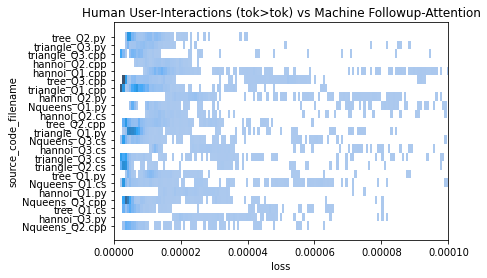

In [94]:
sns.histplot(
    data=df_raw_comparisons[
        df_raw_comparisons["processing_mode"] == "followup"],
    x="loss",
    y="source_code_filename"
)
plt.title("Human User-Interactions (tok>tok) vs Machine Followup-Attention")
plt.xlim(0, .0001)

(0.0, 0.0001)

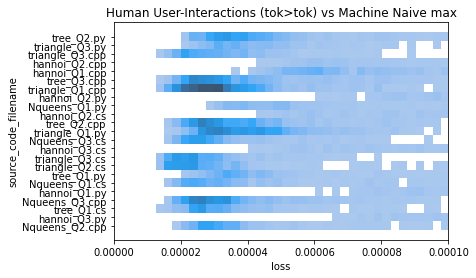

In [95]:
sns.histplot(
    data=df_raw_comparisons[
        df_raw_comparisons["processing_mode"] == "naive_max"],
    x="loss",
    y="source_code_filename"
)
plt.title("Human User-Interactions (tok>tok) vs Machine Naive max")
plt.xlim(0, .0001)

(0.0, 0.0002)

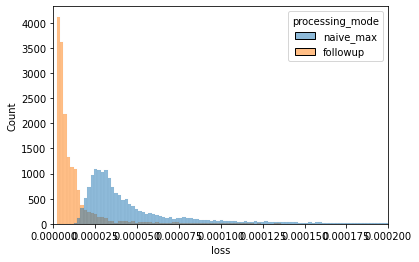

In [99]:
sns.histplot(
    data=df_raw_comparisons,
    hue="processing_mode",
    x="loss",
)
plt.xlim(0, .0002)

# Plot One CodeGen heatmap

This considers only the prompt itself, not the generated code.


(<Figure size 706.8x1123.2 with 1 Axes>, <AxesSubplot:>)

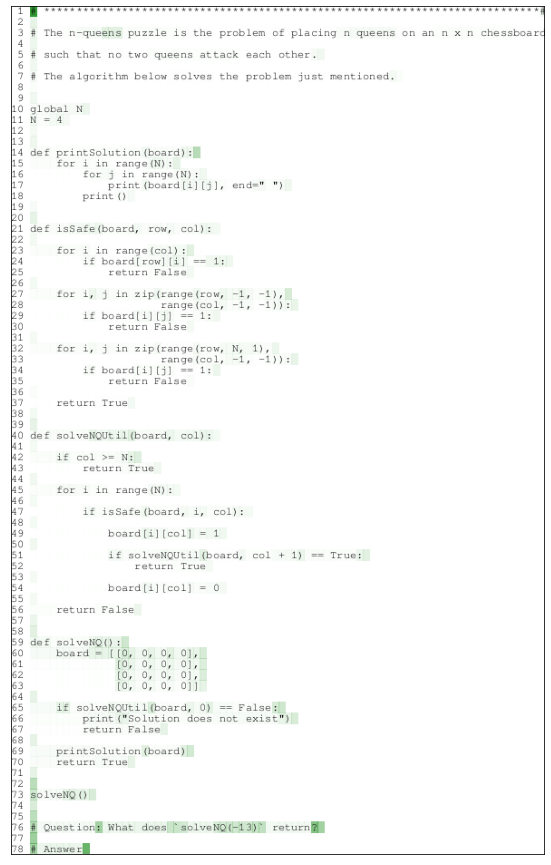

In [79]:
visualize_code_heatmap_codegen(
    filename="Nqueens_Q1.py",
    all_machine_data_vectors=all_machine_data_vector,
    all_machine_data_metadata=all_machine_metadata,
)


IDEA: sum only over the last lines.

Suggestions:
- consider only the attention given to by the other tokens
- take into account recency effects (e.g. multiply each line times a costant depending on the recency of that token, early token get boosted more)
- and token types (e.g. spaces are less intresting than words) or the attention is shifted towards the end of the line. e.g malus for end of the line.
- compute single line attention. Reconstruct the attention matrix between lines.


- interested in predicting the attention from A to B.

## Prepare processing functions

In [22]:
# EXCLUSTION FUNCTIONS
# to exclude certain tokens from the attention matrix condensation

def excude_specific_tokens(
        a: torch.tensor, 
        tokens_prompt: List[str] = None,
        tokens_all: List[str] = None,
        tokens_to_exclude: List[str] = []) -> torch.tensor:
    """Exclude specific tokens."""
    mask = torch.tensor([t in tokens_to_exclude for t in tokens_all])
    expanded_mask = mask.expand(a.shape[1], a.shape[0]).t()
    return a[expanded_mask].reshape(-1, a.shape[1])


def excude_end_of_lines(
        a: torch.tensor, 
        tokens_prompt: List[str] = None,
        tokens_all: List[str] = None,
        eol_token: str = "Ċ") -> torch.tensor:
    """Exclude the end of lines."""
    return excude_specific_tokens(a, tokens_prompt, tokens_all, [eol_token])


def excude_spaces(
        a: torch.tensor, 
        tokens_prompt: List[str] = None,
        tokens_all: List[str] = None,
        space_token: str = "Ġ") -> torch.tensor:
    """Exclude the spaces."""
    return excude_specific_tokens(a, tokens_prompt, tokens_all, [space_token])


def exclude_spaces_and_end_of_lines(
        a: torch.tensor, 
        tokens_prompt: List[str] = None,
        tokens_all: List[str] = None,
        space_token: str = "Ġ",
        eol_token: str = "Ċ") -> torch.tensor:
    """Exclude the spaces and the end of lines."""
    return excude_specific_tokens(
        a, tokens_prompt, tokens_all, [space_token, eol_token])

In [23]:
# PROCESSING LEVEL 0
# processing which do no eliminate any line or columns, but rather zero out 
# some attention weights.
# They can be perofrmed only at the very beginning when the attention matrix
# is square and contains all tokens.

def zeroe_attention_on_itself(
        a: torch.Tensor,
        all_tokens: List[str],
        tokens_prompt: List[str]):
    """For each token, remove the attention it gives to itself."""
    return a - torch.eye(a.shape[0])

In [24]:
# RESTRICTION FUNCTIONS:
# to reduce the attention matrix to only relevant sections

def focus_on_entire_prompt_and_generated_text(
        a: torch.tensor, 
        tokens_prompt: List[str] = None,
        tokens_all: List[str] = None) -> torch.tensor:
    """Focus on the entire prompt and generated text."""
    return a


def focus_on_entire_prompt(
        a: torch.tensor, 
        tokens_prompt: List[str] = None,
        tokens_all: List[str] = None) -> torch.tensor:
    """Focus on the entire prompt only."""
    return a[:len(tokens_prompt), :]


def focus_on_question(
        a: torch.tensor, 
        tokens_prompt: List[str] = None,
        tokens_all: List[str] = None,
        question_token: str = "ĠQuestion") -> torch.tensor:
    """Focus only on the question part of the prompt."""
    try:
        idx_question_token = \
            len(tokens_prompt) - tokens_prompt[::-1].index(question_token)
    except ValueError as e:
        idx_question_token = \
            len(tokens_prompt) - tokens_prompt[::-1].index("ĠQuestions")
    return a[idx_question_token:len(tokens_prompt), :]


def focus_on_new_generated_text(
        a: torch.tensor, 
        tokens_prompt: List[str] = None,
        tokens_all: List[str] = None,) -> torch.tensor:
    """Focus only on the newly generated text."""
    return a[len(tokens_prompt):, :]



In [26]:
# PROCESSING FUNCTION:
# to derive a vector from the attention matrix

def normalize_per_recency(a: torch.tensor) -> torch.tensor:
    """Boost the attention weights by the recency of the token.
    
    It multiplies the attention weights of a given token (aka matrix line)
    by the number of tokens before it (aka matrix line index)."""
    n_tokens_from = a.shape[0]
    n_tokens_to = a.shape[1]
    # create multiplicative mask
    multiplicative_sequence = torch.arange(1, n_tokens_from + 1) ** 0.5
    mult_mask = multiplicative_sequence.expand(n_tokens_to, n_tokens_from).t()
    return a * mult_mask

def normalize_per_recency_and_sum(a: torch.tensor) -> List[float]:
    """Boost the attention weights by the recency of the token."""
    return normalize_per_recency(a).sum(dim=0).tolist()


def normalize_per_recency_and_max(a: torch.tensor) -> List[float]:
    """Boost the attention weights by the recency of the token."""
    return normalize_per_recency(a).amax(dim=0).tolist()


def mean_att_from_followers(a: torch.tensor) -> List[float]:
    """Take the mean att that each toke receives from its followers."""
    denominator_sequence = torch.count_nonzero(a, dim=0)
    # avoid division by zero
    denominator_sequence = torch.max(
        torch.tensor(1.0), denominator_sequence)
    sum_vector = torch.sum(a, dim=0)
    return (sum_vector / denominator_sequence).tolist()

# Loop over matrices

In [30]:
RESTRICTION_FUNCTONS = [
    focus_on_entire_prompt,
    focus_on_entire_prompt_and_generated_text,
    focus_on_question,
    focus_on_new_generated_text,   
]
ATT_EXTRACTION_FUNCTIONS = [
    normalize_per_recency_and_sum,
    normalize_per_recency_and_max,
    mean_att_from_followers,
]


 37%|███▋      | 14/38 [00:00<00:00, 133.49it/s]

UbagU  -  python/tree_Q2.py
dict_keys(['user_name', 'task_number', 'source_code', 'tokenization', 'raw_text'])
UbeerU  -  python/triangle_Q3.py
dict_keys(['user_name', 'task_number', 'source_code', 'tokenization', 'raw_text'])
UconsumerU  -  cpp/triangle_Q3.cpp
dict_keys(['user_name', 'task_number', 'source_code', 'tokenization', 'raw_text'])
UbagU  -  python/multithread_Q1.py
multithread_Q1.py not found in att_matrices
UconsumerU  -  cpp/hannoi_Q2.cpp
dict_keys(['user_name', 'task_number', 'source_code', 'tokenization', 'raw_text'])
UdragonU  -  cpp/hannoi_Q1.cpp
dict_keys(['user_name', 'task_number', 'source_code', 'tokenization', 'raw_text'])
UconsumerU  -  cpp/tree_Q3.cpp
dict_keys(['user_name', 'task_number', 'source_code', 'tokenization', 'raw_text'])
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1864 and the array at index 1 has size 1862
all the input array dimensions for the concatenation axis

100%|██████████| 38/38 [00:00<00:00, 128.94it/s]


UbottleU  -  python/hannoi_Q2.py
dict_keys(['user_name', 'task_number', 'source_code', 'tokenization', 'raw_text'])
UquarterU  -  cpp/hannoi_Q1.cpp
dict_keys(['user_name', 'task_number', 'source_code', 'tokenization', 'raw_text'])
UdragonU  -  cpp/tree_Q2.cpp
dict_keys(['user_name', 'task_number', 'source_code', 'tokenization', 'raw_text'])
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1796 and the array at index 1 has size 1794
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1796 and the array at index 1 has size 1794
UsalvationU  -  csharp/tree_Q1.cs
dict_keys(['user_name', 'task_number', 'source_code', 'tokenization', 'raw_text'])
UmonkU  -  cpp/hannoi_Q1.cpp
dict_keys(['user_name', 'task_number', 'source_code', 'tokenization', 'raw_text'])
UimproveU  -  python/hannoi_Q3.py
dict_keys(['user_name', 'task_number', 'sour

In [31]:
print(len(df_res))
df_res.head()

56


,source_code,user_name,task_number,mapping_from_token_to_char,correlation,pvalue
0,tree_Q2.py,UbagU,2,equal_share,0.033195,0.166831
1,tree_Q2.py,UbagU,2,replication,0.060502,0.011692
2,triangle_Q3.py,UbeerU,2,equal_share,0.079873,0.003609
3,triangle_Q3.py,UbeerU,2,replication,0.067546,0.013889
4,triangle_Q3.cpp,UconsumerU,3,equal_share,0.060828,0.010698


In [32]:
df_legit_res = df_res[df_res["pvalue"] <= 0.05]

In [33]:
def visualize_corr_vs(
        df: pd.DataFrame,  
        col_to_inspect: str,
        corr_col: str = "correlation"):
    """Check the relationship between correlation and the given variable."""
    fig, axes = plt.subplots(2, 1, figsize=(10, 5))
    ax_hist = axes[0]
    ax_violin = axes[1]
    # HISTGRAM
    sns.histplot(
        data=df_legit_res,
        x=corr_col,
        multiple="stack",
        hue=col_to_inspect,
        ax= ax_hist,
    )
    ax_hist.axvline(0, color="red", linestyle="--")
    ax_hist.set_xlim(-1, 1)
    # VIOLINPLOT
    sns.violinplot(
        data=df_legit_res,
        x=corr_col,
        y=col_to_inspect
    )
    ax_violin.set_xlim(-1, 1)
    plt.tight_layout()


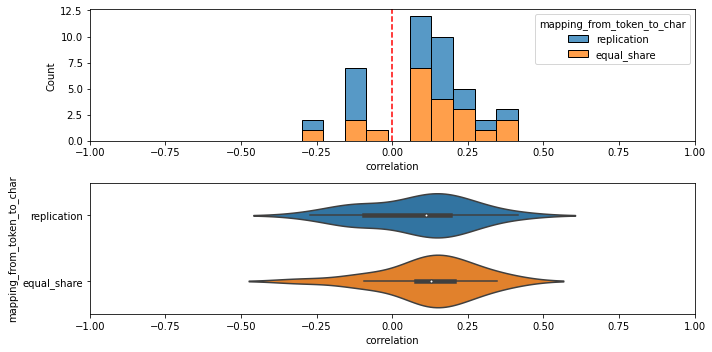

In [35]:
visualize_corr_vs(
    df_legit_res,
    col_to_inspect="mapping_from_token_to_char",
)

(-1.0, 1.0)

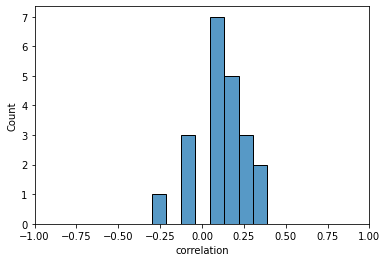

In [36]:
df_best_selection = df_legit_res[
    (df_legit_res["mapping_from_token_to_char"] == "equal_share") #&
    #(df_legit_res["extraction_function"] == "mean_att_from_followers") &
    #(df_legit_res["restriction_function"] == "focus_on_entire_prompt")
]

sns.histplot(
    data=df_best_selection,
    x="correlation"
)
plt.xlim(-1, 1)

# Inter-Rater Agreement

## HRR vs Eye-Tracking

In [115]:
hrr_human_data = read_data_in_parallel(
    base_folder="../data/hrr/hrr_v01/att_weights",
    file_type_extension=".npy",    
)

hrr_human_metadata = {
    k: {
        "source_code": k.split("_")[1].replace("Q1", "_Q1.").replace("Q2", "_Q2.").replace("Q3", "_Q3.")} 
    for k, v in hrr_human_data.items()
}

hrr_human_data.keys()

n of data read:  3


dict_keys(['A2IG18D6M0GNUZ_hannoiQ1py_0e1adace34bb5ff9f999865e1605b466', 'A2IG18D6M0GNUZ_NqueensQ3py_0e1adace34bb5ff9f999865e1605b466', 'A2IG18D6M0GNUZ_triangleQ3py_0e1adace34bb5ff9f999865e1605b466'])

In [116]:
hrr_human_metadata

{'A2IG18D6M0GNUZ_hannoiQ1py_0e1adace34bb5ff9f999865e1605b466': {'source_code': 'hannoi_Q1.py'},
 'A2IG18D6M0GNUZ_NqueensQ3py_0e1adace34bb5ff9f999865e1605b466': {'source_code': 'Nqueens_Q3.py'},
 'A2IG18D6M0GNUZ_triangleQ3py_0e1adace34bb5ff9f999865e1605b466': {'source_code': 'triangle_Q3.py'}}

In [118]:
records_hrr_vs_eye = []
for k_hrr, hrr_data in hrr_human_data.items():
    hrr_filename = hrr_human_metadata[k_hrr]["source_code"]

    # get all the eye tracking data corresponding to the same file
    for k_eye, eye_data in all_human_data.items():
        eye_filename = all_human_metadata[k_eye]["source_code"]
        if hrr_filename in eye_filename:
            # match
            correlation = spearmanr(hrr_data, eye_data)
            new_record = {
                "source_code": hrr_filename,
                "human_hrr": k_hrr,
                "human_eye": k_eye,
                "correlation": correlation.correlation,
                "pvalue": correlation.pvalue,
            }
            records_hrr_vs_eye.append(new_record)

df_hrr_vs_eye = pd.DataFrame.from_records(records_hrr_vs_eye)
df_hrr_vs_eye.head()

,source_code,human_hrr,human_eye,correlation,pvalue
0,hannoi_Q1.py,A2IG18D6M0GNUZ_hannoiQ1py_0e1adace34bb5ff9f999...,5403f5,0.378654,7.622533e-25
1,hannoi_Q1.py,A2IG18D6M0GNUZ_hannoiQ1py_0e1adace34bb5ff9f999...,9fd0c1,0.334541,1.994417e-19
2,triangle_Q3.py,A2IG18D6M0GNUZ_triangleQ3py_0e1adace34bb5ff9f9...,08147e,0.309153,8.794258e-31
3,triangle_Q3.py,A2IG18D6M0GNUZ_triangleQ3py_0e1adace34bb5ff9f9...,2babb5,0.270434,1.130238e-23
4,triangle_Q3.py,A2IG18D6M0GNUZ_triangleQ3py_0e1adace34bb5ff9f9...,88a31c,0.396568,3.239603e-51


## Eye tracking inter rater agreement

In [25]:
map_snippet_to_humans = {}
map_snippet_to_human_data = {}


for unique_data_id in tqdm(all_human_data.keys()):
    c_human_data = all_human_data[unique_data_id]
    c_human_metadata = all_human_metadata[unique_data_id]
    source_snippet = c_human_metadata["source_code"]
    if source_snippet not in map_snippet_to_humans.keys():
        map_snippet_to_humans[source_snippet] = [unique_data_id]
        map_snippet_to_human_data[source_snippet] = [c_human_data]
    else:
        map_snippet_to_humans[source_snippet] += [unique_data_id]
        map_snippet_to_human_data[source_snippet] += [c_human_data]


map_snippet_to_humans

100%|██████████| 88/88 [00:00<00:00, 333121.62it/s]


{'python/tree_Q2.py': ['0480e5', '5a70af'],
 'python/triangle_Q3.py': ['08147e',
  '2babb5',
  '88a31c',
  'aecca4',
  'b6cb6e',
  'b84310'],
 'cpp/triangle_Q3.cpp': ['09601c'],
 'python/hannoi_Q2.py': ['0d7601', '3d9b54', 'afc047', 'c6d8ff'],
 'python/multithread_Q2.py': ['1181b7',
  '4a262b',
  '4c260d',
  'b93c2f',
  'd41dd8'],
 'csharp/hannoi_Q1.cs': ['155d45', '44d4f6', 'b7971a', 'f4bbec'],
 'python/multithread_Q1.py': ['161f21', 'd401e5'],
 'cpp/hannoi_Q2.cpp': ['1d5b6a'],
 'cpp/hannoi_Q1.cpp': ['300bd1', 'b0172f', 'c35fdf'],
 'cpp/tree_Q3.cpp': ['38606b', '448383'],
 'cpp/triangle_Q1.cpp': ['3b0e57', '7740fd', 'c7ca22'],
 'csharp/multithread_Q3.cs': ['3b39e2'],
 'python/Nqueens_Q1.py': ['3e474f'],
 'csharp/hannoi_Q2.cs': ['4022a9', 'ab3a90', 'e63ddf'],
 'cpp/tree_Q2.cpp': ['403482', 'b5c173'],
 'csharp/tree_Q2.cs': ['43e18c', '98a211', '9e5778', 'cbdc06'],
 'python/triangle_Q1.py': ['44e060', '675fc1', 'df2957'],
 'csharp/tree_Q1.cs': ['4a5896', 'bda0b1', 'd3a4b4'],
 'python/tre

In [26]:
from itertools import combinations

all_human_human_records = []

for filename, data_ids_same_task in map_snippet_to_humans.items():
    if len(data_ids_same_task) > 1:
        print(filename, len(data_ids_same_task))
        # for each combination of humans
        all_combinations = combinations(data_ids_same_task, 2)
        for c_combination in all_combinations:
            human_a = c_combination[0]
            human_b = c_combination[1]
            print(f"human_a: {human_a}")
            print(f"human_b: {human_b}")
            print(
                all_human_metadata[human_a]["user_name"], 
                all_human_metadata[human_a]["user_name"])
            # the two people might have had slightly different input files
            # so we discard those comparisons for now
            if len(all_human_data[human_a]) != len(all_human_data[human_b]):
                print("Skipping comparison because of different lengths")
                continue
            correlation = spearmanr(all_human_data[human_a], all_human_data[human_b])
            new_record = {
                "source_code": filename,
                "human_a": all_human_metadata[human_a]["user_name"],
                "human_b": all_human_metadata[human_b]["user_name"],
                "task_nr_a": all_human_metadata[human_a]["task_number"],
                "task_nr_b": all_human_metadata[human_b]["task_number"],
                "correlation": correlation.correlation,
                "pvalue": correlation.pvalue,
            }
            all_human_human_records.append(new_record)

df_human_human_res = pd.DataFrame.from_records(all_human_human_records)
df_human_human_res.head()

python/tree_Q2.py 2
human_a: 0480e5
human_b: 5a70af
UbagU UbagU
python/triangle_Q3.py 6
human_a: 08147e
human_b: 2babb5
UbeerU UbeerU
human_a: 08147e
human_b: 88a31c
UbeerU UbeerU
human_a: 08147e
human_b: aecca4
UbeerU UbeerU
human_a: 08147e
human_b: b6cb6e
UbeerU UbeerU
human_a: 08147e
human_b: b84310
UbeerU UbeerU
human_a: 2babb5
human_b: 88a31c
UseaU UseaU
human_a: 2babb5
human_b: aecca4
UseaU UseaU
human_a: 2babb5
human_b: b6cb6e
UseaU UseaU
human_a: 2babb5
human_b: b84310
UseaU UseaU
human_a: 88a31c
human_b: aecca4
UcamelionU UcamelionU
human_a: 88a31c
human_b: b6cb6e
UcamelionU UcamelionU
human_a: 88a31c
human_b: b84310
UcamelionU UcamelionU
human_a: aecca4
human_b: b6cb6e
UsleepU UsleepU
human_a: aecca4
human_b: b84310
UsleepU UsleepU
human_a: b6cb6e
human_b: b84310
UmosquitoU UmosquitoU
python/hannoi_Q2.py 4
human_a: 0d7601
human_b: 3d9b54
UsleepU UsleepU
human_a: 0d7601
human_b: afc047
UsleepU UsleepU
human_a: 0d7601
human_b: c6d8ff
UsleepU UsleepU
human_a: 3d9b54
human_b: afc

,source_code,human_a,human_b,task_nr_a,task_nr_b,correlation,pvalue
0,python/tree_Q2.py,UbagU,UbottleU,2,1,0.411864,4.300789e-72
1,python/triangle_Q3.py,UbeerU,UseaU,2,2,0.584488,2.048601e-122
2,python/triangle_Q3.py,UbeerU,UcamelionU,2,2,0.565977,3.054217e-113
3,python/triangle_Q3.py,UbeerU,UsleepU,2,3,0.514072,2.136541e-90
4,python/triangle_Q3.py,UbeerU,UmosquitoU,2,2,0.595480,3.791150e-128


In [27]:
# keep only the ones that are legit, namely with a pvalue lower than 0.05
df_legit_human_human_res = df_human_human_res[df_human_human_res["pvalue"] < 0.05]

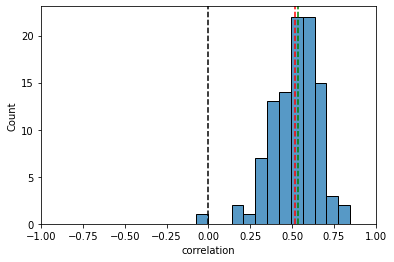

In [28]:
sns.histplot(
    data=df_legit_human_human_res,
    x="correlation"
)
plt.xlim(-1, 1)
# create vertical line with the mean
plt.axvline(
    df_legit_human_human_res["correlation"].mean(),
    color="red",
    linestyle="--",
)
# create vertical line with the median
plt.axvline(
    df_legit_human_human_res["correlation"].median(),
    color="green",
    linestyle="--",
)
# create vertical line in the middle
plt.axvline(
    0,
    color="black",
    linestyle="--",
)

## Side by Side comparison

In [47]:
# compare two attention maps side by side
def visualize_human_att_maps(path_human_a, path_human_b):
    """Visualize the attention maps of two humans."""
    human_a = json.load(open(path_human_a, 'r'))
    human_b = json.load(open(path_human_b, 'r'))
    for human_data in [human_a, human_b]:
        source = SourceCode(
            tokens=human_data["tokenization"]
        )
        source.show_with_weights(
            weights=human_data["att_weights"],
            show_line_numbers=True,
        )
        plt.show()


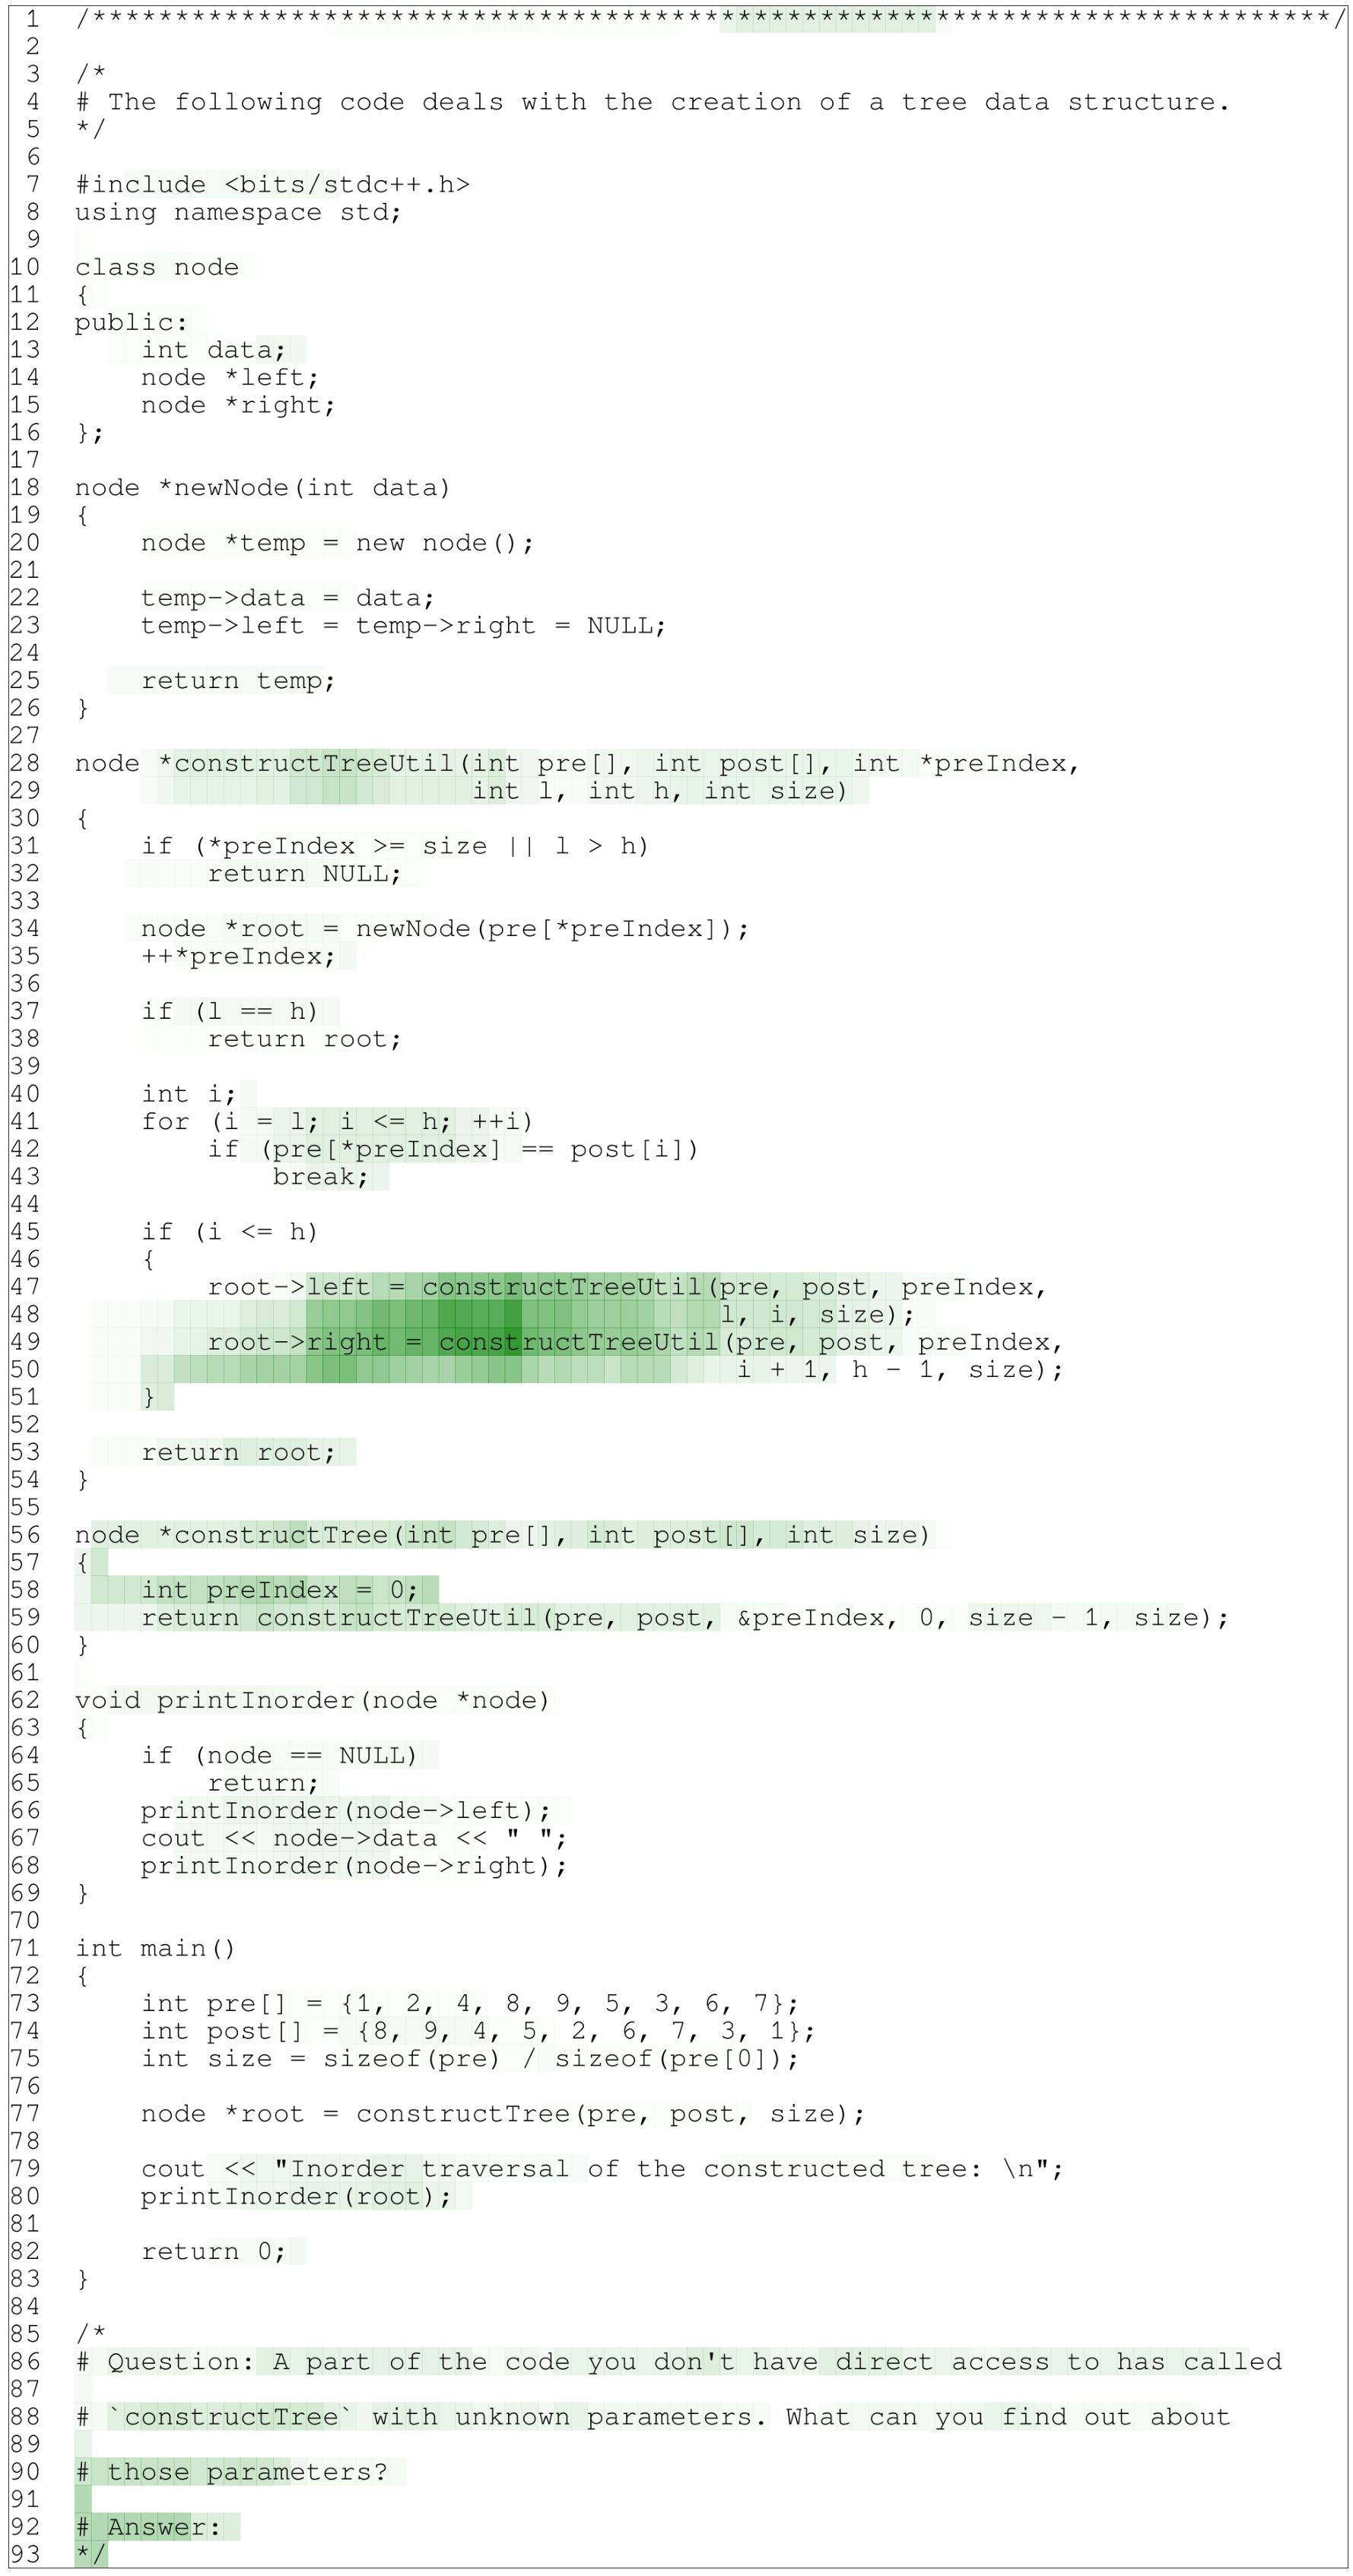

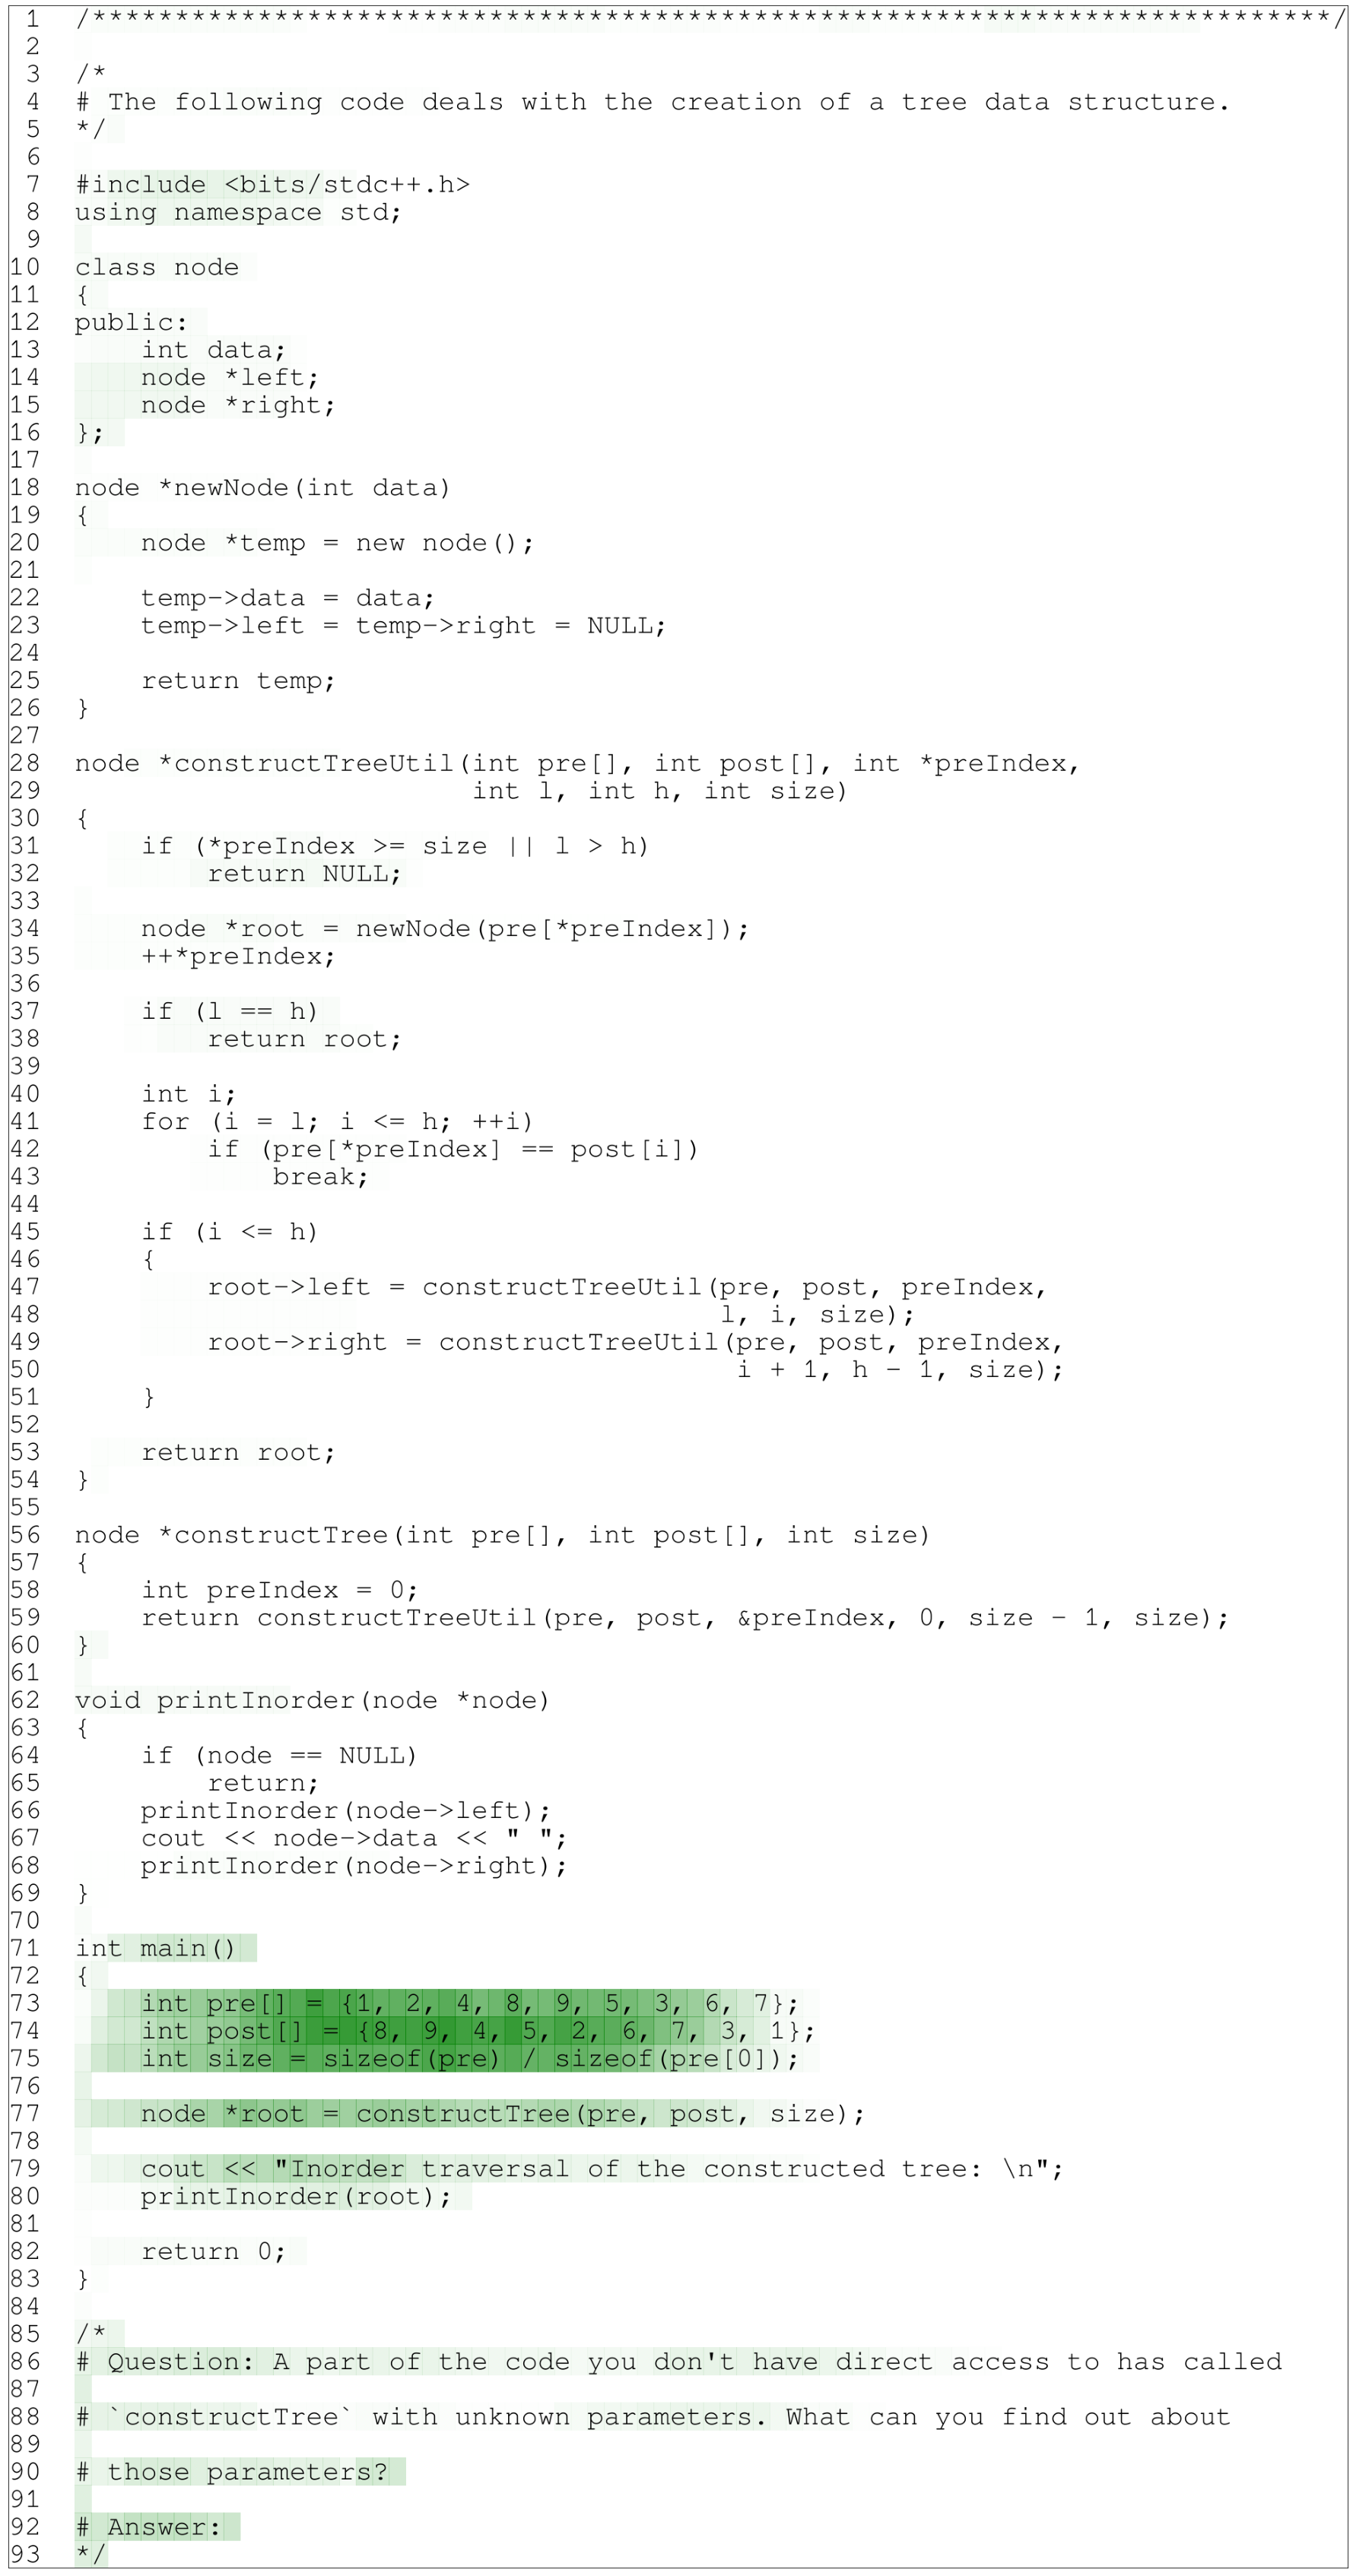

In [48]:

visualize_human_att_maps(
    path_human_a=f"../data/eye_tracking_attention/{HUMAN_EXPERIMENT}/UconsumerU_2.json",
    path_human_b=f"../data/eye_tracking_attention/{HUMAN_EXPERIMENT}/UquarterU_2.json"
)